<center><font size = "10"> Week 10 - Network Stimulation<center>
<center><font size = "8">Home Work <center>

### Compiling the MOD file

In [1]:
!nrnivmodl 

/home/In Silico/Week 10
vecevent.mod
vecevent.mod
"/usr/local/nrn/share/nrn/libtool" --tag=CC --mode=compile gcc -DHAVE_CONFIG_H  -I. -I.. -I"/usr/local/nrn/include/nrn" -I"/usr/local/nrn/x86_64/lib"      -g -O2 -c -o mod_func.lo mod_func.c
libtool: compile:  gcc -DHAVE_CONFIG_H -I. -I.. -I/usr/local/nrn/include/nrn -I/usr/local/nrn/x86_64/lib -g -O2 -c mod_func.c  -fPIC -DPIC -o .libs/mod_func.o
"/usr/local/nrn/share/nrn/libtool" --tag=CC --mode=link gcc -module  -g -O2    -o libnrnmech.la -rpath "/usr/local/nrn/x86_64/lib"  vecevent.lo mod_func.lo  -L"/usr/local/nrn/x86_64/lib" -lnrnoc -loc -lmemacs  -lscopmath -lsparse13 -lreadline -lncurses -ltinfo -L"/usr/local/nrn/x86_64/lib" -lnrniv -livoc -lneuron_gnu -lmeschach -lsundials       -lm -ldl
libtool: link: rm -fr  .libs/libnrnmech.la .libs/libnrnmech.lai .libs/libnrnmech.so .libs/libnrnmech.so.0 .libs/libnrnmech.so.0.0.0
libtool: link: gcc -shared  -fPIC -DPIC  .libs/vecevent.o .libs/mod_func.o   -Wl,-rpath -Wl,/usr/local/nrn/x86_6

# Ex1. Irregular asynchrounous stimulation

<font size='3'>
Load the five morphology reconstructions assigned to your group in week 2 using the class "Cell" defined in the tutorials. 
Connect the pyramidal cells with weight = 1.0, similar to tutorial 01. Add exponential synapses (weight 1.0, tau = 2 ms) to a random section of the basal dendrite of each cell. Create an irregular asynchronous stimulation and apply it to each exponential synapse. Run a simulation that lasts at least past the last stimulation and plot the cells voltage response and spikes. What do you observe ? [1 pt]

In [3]:
# Importing useful libraries

%matplotlib inline

from neuron import h, gui
import matplotlib.pyplot as plt
import numpy as np
import random

random.seed(9)
np.random.seed(9)
# Load external files & initialize
h.load_file("stdrun.hoc");
h.stdinit();

### Defining the Cell Class and loading the 3 morphologies of Pyramidal Cells

In [4]:
class Cell:
    def __init__(self, filename, name, cell_type):
        self.name = name
        self.type = cell_type
        self.synapses = []
        self.build_morphology(filename)
        self.biophysics()
        
    def build_morphology(self, filename):
        h.load_file('import3d.hoc')
        h.load_file('stdlib.hoc')
        #morph_reader = h.Import3d_Neurolucida3()
        morph_reader = h.Import3d_SWC_read()
        morph_reader.input(filename)
        i3d = h.Import3d_GUI(morph_reader, 0)
        i3d.instantiate(self) # Notice this change to be able to instantiate several cells
    
    def biophysics(self):
        for sec in h.allsec():
            sec.Ra = 100    # Axial resistance in Ohm * cm
            sec.cm = 1      # Membrane capacitance in micro Farads / cm^2
            sec.insert("pas")
            for seg in sec:
                seg.pas.g = 0.00003
                seg.pas.e = -75
        
        # Insert passive current in the dendrite
        for sec in self.soma:
            sec.insert('hh')
            for seg in sec:
                seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
                seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2
        
        if hasattr(self, 'apic'):
            for sec in self.apic:
                sec.insert('hh')
                for seg in sec:
                    seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
                    seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2
        
        for sec in self.dend:
            sec.insert('hh')
            for seg in sec:
                seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
                seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2
                
        for sec in self.axon:
            sec.insert('hh')
            for seg in sec:    
                seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
                seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2

In [5]:
Pyr1 = Cell('morph_06.swc','Pyr1','Pyr')
Pyr2 = Cell('morph_07.swc','Pyr2','Pyr')
Pyr3 = Cell('morph_09.swc','Pyr3','Pyr')
cells_Pyr = [Pyr1, Pyr2, Pyr3]

error morph_06.swc line 17828: could not parse: 
error morph_07.swc line 19678: could not parse: 
error morph_09.swc line 6173: could not parse: 


In [6]:
for c in cells_Pyr:
    print('%s: %d apical sections, %d basal sections, %d soma sections and %d axon senctions' % (c.name,len(c.apic),len(c.dend), len(c.soma), len(c.axon)))

Pyr1: 95 apical sections, 72 basal sections, 2 soma sections and 131 axon senctions
Pyr2: 131 apical sections, 82 basal sections, 2 soma sections and 125 axon senctions
Pyr3: 37 apical sections, 69 basal sections, 2 soma sections and 67 axon senctions


### Connecting Pyramidal cells with weight = 1.0

In [7]:
# connect two cells with an exponential synapse at given locations
# returns the netcon
def connect(source, target, weight = None, delay = 5, source_sec = None, source_neurite = 'axon', target_sec = None, target_neurite = 'dend'):
    rng = np.random.default_rng()
    
    if weight is None:
        weight = rng.uniform() # random weight
    
    target_neurite_ = getattr(target, target_neurite)
    if target_sec is None:
        target_sec = rng.integers(0,len(target_neurite_)) # random dendritic section
    
    source_neurite_ = getattr(source, source_neurite)
    if source_sec is None:
        source_sec = rng.integers(0,len(source_neurite_)) # random axonal section
    
    target_syn = h.ExpSyn(target_neurite_[target_sec](0.5))
    target.synapses.append(target_syn) # store synapse
    
    netcon = h.NetCon(source_neurite_[source_sec](0.5)._ref_v, target_syn, sec=source_neurite_[source_sec])
    netcon.weight[0] = weight
    netcon.delay = delay
    
    print('Connected cells %s -> %s with weight %g and delay %g, from %s[%d] to %s[%d]' % (source.name,target.name,weight,delay,source_neurite,source_sec,target_neurite,target_sec))
    return netcon

In [8]:
netcons = [] # save the netcons in case we want to modify them later

# Connect Pyr2 and Pyr3 to Pyr1
nc = connect(Pyr2,Pyr1,weight = 1.0)
netcons.append(nc)
nc = connect(Pyr3,Pyr1,weight = 1.0)
netcons.append(nc)

# Connect Pyr1 and Pyr3 to Pyr2
nc = connect(Pyr1,Pyr2,weight = 1.0)
netcons.append(nc)
nc = connect(Pyr3,Pyr2,weight = 1.0)
netcons.append(nc)

# Connect Pyr1 and Pyr2 to Pyr3
nc = connect(Pyr1,Pyr3,weight = 1.0)
netcons.append(nc)
nc = connect(Pyr2,Pyr3,weight = 1.0)
netcons.append(nc)

Connected cells Pyr2 -> Pyr1 with weight 1 and delay 5, from axon[49] to dend[63]
Connected cells Pyr3 -> Pyr1 with weight 1 and delay 5, from axon[60] to dend[57]
Connected cells Pyr1 -> Pyr2 with weight 1 and delay 5, from axon[99] to dend[5]
Connected cells Pyr3 -> Pyr2 with weight 1 and delay 5, from axon[12] to dend[5]
Connected cells Pyr1 -> Pyr3 with weight 1 and delay 5, from axon[81] to dend[68]
Connected cells Pyr2 -> Pyr3 with weight 1 and delay 5, from axon[110] to dend[14]


### Adding exponential synapses to random section of basal dendrite of each cell

In [9]:
import random
# Place exponential synapses in random cell sections
random.seed(9)
np.random.seed(9)
# Exponential synapses
# Cell 1
sec1 = random.randint(0, len(Pyr1.dend)-1)
stim_cell1 = Pyr1
synapse1 = h.ExpSyn(stim_cell1.dend[sec1](0.5))
synapse1.tau = 2 # ms
print ('Stimulus apply in basal section num %s of Pyr1' %sec1)

# Cell 2
sec2 = random.randint(0, len(Pyr2.dend)-1)
stim_cell2 = Pyr2
synapse2 = h.ExpSyn(stim_cell2.dend[sec2](0.5))
synapse2.tau = 2 # ms
print ('Stimulus apply in basal section num %s of Pyr2' %sec2)

# Cell 3
stim_cell3 = Pyr3
sec3 = random.randint(0, len(Pyr3.dend)-1)
synapse3 = h.ExpSyn(stim_cell3.dend[sec3](0.5))
synapse3.tau = 2 # ms
print ('Stimulus apply in basal section num %s of Pyr3' %sec3)

Stimulus apply in basal section num 59 of Pyr1
Stimulus apply in basal section num 78 of Pyr2
Stimulus apply in basal section num 47 of Pyr3


### Create irregular asynchronous stimulation and apply to each exponential synapse

In [10]:
# Create random stimulation times
random.seed(9)
np.random.seed(9)
stim_times1 = [20.0]
for t in range(1, 7):
    n = random.randint(10.0,50.0)
    step = stim_times1[t-1] + n
    stim_times1.append(step)
# Check what is the output
print('stimulation interval 1 = %s' %stim_times1)

stim_times2 = [30.0]
for t in range(1, 7):
    n = random.randint(10.0,50.0)
    step = stim_times2[t-1] + n
    stim_times2.append(step)
# Check what is the output
print('stimulation interval 2 = %s' %stim_times2)

stim_times3 = [10.0]
for t in range(1, 7):
    n = random.randint(10.0,50.0)
    step = stim_times3[t-1] + n
    stim_times3.append(step)
# Check what is the output
print('stimulation interval 3 = %s' %stim_times3)

stimulation interval 1 = [20.0, 59.0, 108.0, 141.0, 168.0, 186.0, 207.0]
stimulation interval 2 = [30.0, 40.0, 71.0, 113.0, 152.0, 200.0, 215.0]
stimulation interval 3 = [10.0, 41.0, 86.0, 135.0, 147.0, 181.0, 201.0]


In [11]:
# Stimulator
stimulator1 = h.VecStim()
spike_times1 = stim_times1
spikes_vector1 = h.Vector(spike_times1)
stimulator1.play(spikes_vector1)

stimulator2 = h.VecStim()
spike_times2 = stim_times2
spikes_vector2 = h.Vector(spike_times2)
stimulator2.play(spikes_vector2)

stimulator3 = h.VecStim()
spike_times3 = stim_times3
spikes_vector3 = h.Vector(spike_times3)
stimulator3.play(spikes_vector3)

connection1 = h.NetCon(stimulator1, synapse1)
connection1.weight[0] = 1.0        # In units of [nS] due to the gmax scaling factor in our .mod file
connection2 = h.NetCon(stimulator2, synapse2)
connection2.weight[0] = 1.0        # In units of [nS] due to the gmax scaling factor in our .mod file
connection3 = h.NetCon(stimulator3, synapse3)
connection3.weight[0] = 1.0        # In units of [nS] due to the gmax scaling factor in our .mod file

### Running a simulation that lasts at least part of stimulation and plotting cell voltage response and spikes

In [12]:
recording_cell1 = Pyr1
recording_cell2 = Pyr2
recording_cell3 = Pyr3

soma_v1 = h.Vector().record(recording_cell1.soma[0](0.5)._ref_v)
soma_v2 = h.Vector().record(recording_cell2.soma[0](0.5)._ref_v)
soma_v3 = h.Vector().record(recording_cell3.soma[0](0.5)._ref_v)

time = h.Vector().record(h._ref_t)

h.finitialize(-65)
h.continuerun(500)

0.0

<span style="color:red"> NB: sometimes when running this cell, the pyramidal cells will fire during the stimulation and then shut off. But other times it will continue firing regularly as seen in the tutorial... As a result, if the cells fire only during the stimulation times, then please rerun the cells of exercise 1 (and you may need to redo so several times).

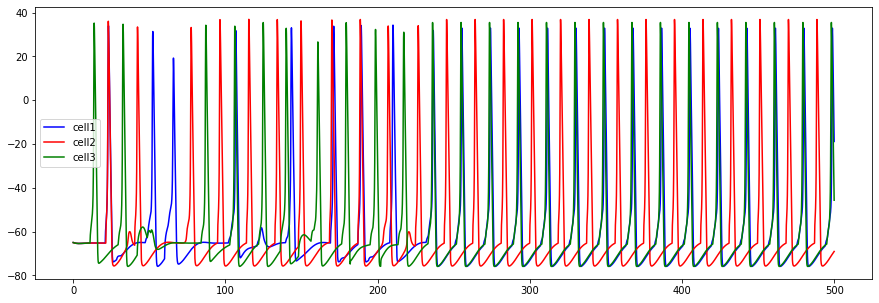

In [13]:
plt.figure(figsize=(15,5))
plt.plot(time, soma_v1, label='cell1', color='blue')
plt.plot(time, soma_v2, label='cell2', color='red')
plt.plot(time, soma_v3, label='cell3', color='green')
plt.legend()
plt.show()

In [14]:
from scipy.signal import find_peaks

def spike_detector(voltage, threshold):
    # convert Neuron recording (voltage) to list
    voltage_read = []
    for v in voltage:
        voltage_read.append(v)
    # peak locations
    spike_time, _ = find_peaks(voltage_read, height=threshold)
    return spike_time
                
# You should adjust this threshold to your needs                
spikes1 = spike_detector(soma_v1, -20.0)
spikes2 = spike_detector(soma_v2, -20.0)
spikes3 = spike_detector(soma_v3, -20.0)

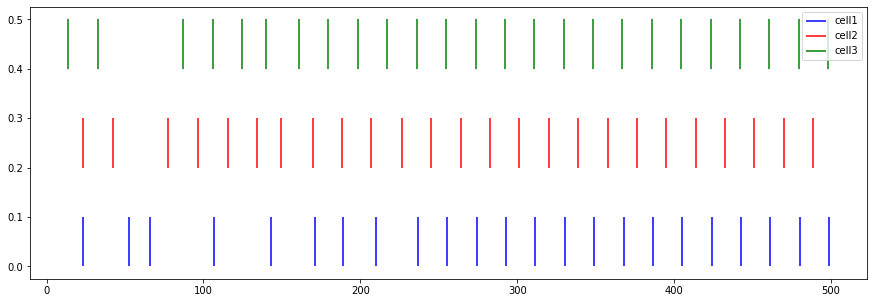

In [15]:
plt.figure(figsize=(15,5))
plt.vlines(spikes1/40, ymin=0, ymax=0.1, color='blue', label='cell1')
plt.vlines(spikes2/40, ymin=0.2, ymax=0.3, color='red', label='cell2')
plt.vlines(spikes3/40, ymin=0.4, ymax=0.5, color='green', label='cell3')
plt.legend()

In [16]:
print("Computing interspike timing during stimulation:")
print("Pyramidal cell 1: "+str((spikes1[1] - spikes1[0])/40))
print("Pyramidal cell 2: "+str((spikes2[1] - spikes2[0])/40))
print("Pyramidal cell 3: "+str((spikes3[1] - spikes3[0])/40))

print("Computing interspike timing after stimulation:")
print("Pyramidal cell 1: "+str((spikes1[-1] - spikes1[-2])/40))
print("Pyramidal cell 2: "+str((spikes2[-1] - spikes2[-2])/40))
print("Pyramidal cell 3: "+str((spikes3[-1] - spikes3[-2])/40))

Computing interspike timing during stimulation:
Pyramidal cell 1: 29.15
Pyramidal cell 2: 19.175
Pyramidal cell 3: 18.975
Computing interspike timing after stimulation:
Pyramidal cell 1: 18.725
Pyramidal cell 2: 18.725
Pyramidal cell 3: 18.725


#### During Stimulation ISI Histogram

In [17]:
threshold = 300*40

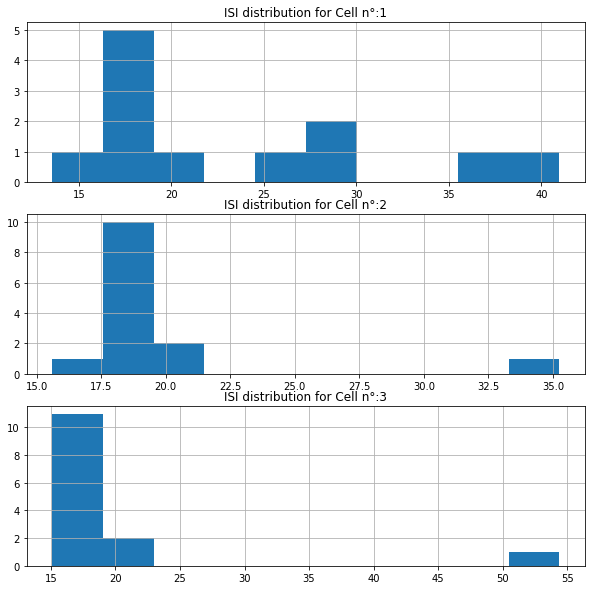

In [18]:
# Plotting the Interspike Interval distribution of the cells
all_ISI = []
ISI_1 = []
ISI_2 = []
ISI_3 = []

for time in range(len(spikes1)-1):
    if spikes1[time] < threshold:
        diff_time = (spikes1[time+1]-spikes1[time])/40
        ISI_1.append(diff_time)
all_ISI.append(ISI_1)

for time in range(len(spikes2)-1):
    if spikes2[time] < threshold:
        diff_time = (spikes2[time+1]-spikes2[time])/40
        ISI_2.append(diff_time)
all_ISI.append(ISI_2)
   
for time in range(len(spikes3)-1):
    if spikes3[time] < threshold:
        diff_time = (spikes3[time+1]-spikes3[time])/40
        ISI_3.append(diff_time)
all_ISI.append(ISI_3)


fig = plt.figure(figsize = (10,10))

for i in range(len(all_ISI)):
    axes = fig.add_subplot(3, 1, i+1)

    axes.hist(all_ISI[i], bins=10)
    axes.set_title("ISI distribution for Cell n°:"+str(i+1))
    axes.grid(True)

#### Post Stimulation ISI Histogram

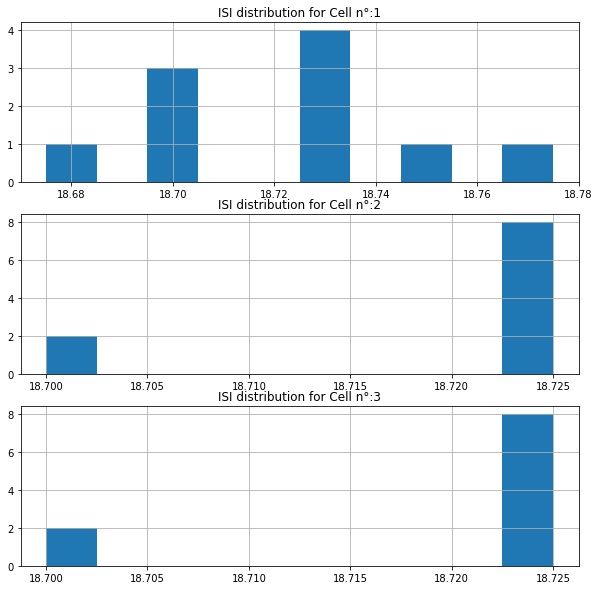

In [19]:
# Plotting the Interspike Interval distribution of the cells
all_ISI = []
ISI_1 = []
ISI_2 = []
ISI_3 = []

for time in range(len(spikes1)-1):
    if spikes1[time] > threshold:
        diff_time = (spikes1[time+1]-spikes1[time])/40
        ISI_1.append(diff_time)
all_ISI.append(ISI_1)

for time in range(len(spikes2)-1):
    if spikes2[time] > threshold:
        diff_time = (spikes2[time+1]-spikes2[time])/40
        ISI_2.append(diff_time)
all_ISI.append(ISI_2)
   
for time in range(len(spikes3)-1):
    if spikes3[time] > threshold:
        diff_time = (spikes3[time+1]-spikes3[time])/40
        ISI_3.append(diff_time)
all_ISI.append(ISI_3)


fig = plt.figure(figsize = (10,10))

for i in range(len(all_ISI)):
    axes = fig.add_subplot(3, 1, i+1)

    axes.hist(all_ISI[i], bins=10)
    axes.set_title("ISI distribution for Cell n°:"+str(i+1))
    axes.grid(True)

### What do you observe ?

In this particular case, we connected three pyramidal cells, with a probability connection of 1.0.  These three pyramidal cells were then respectively stimulated with stimulation times which were randomly chosen starting at different times.  We observe the following:

- During the period with random stimulation time, the variability of these lead the three pyramidal cells to fire irregularly and asynchronously
- However, when the stimulation is stopped, the firing patterns become regular after a short delay (which differs slightly between the three pyramidal cells)
- After the external stimulation, the interspike interval between the three cells is almost identical.  Indeed, when plotting the interspike interval distribution, they have similar ISI distributions.  As a result, these cells fire regularly with the same periodicity, but are asynchronous.

As we saw in the lecture regarding week 7, in Andersen et al.'s (2007) paper, this corresponds to a case of reccurent excitation. Indeed, according to the paper, "local principal cells are in contact with other local principal cells, providing an excitatory mechanism for concerted, temporally coordinated population ouput".  In this case, when the stimulation stops, we do notice this excitatory effect, as the pyramidal cells keep firing regularly with approximately the same period, but they are asyncrhonous.

In the ISI distribution, it is interesting to note that for pyramidal cell 1, 2, and 3, we have the same value which stands out particularly in all three histograms (it varies according to the computer on which it is run for unknown reasons, but the value is around 15-20).

# Ex2. Irregular asynchrounous stimulation with interneurons

<font size='3'>Perform the same simulation as before, but this time add the interneuron cells to your network with the following weights:
w(Pyr - Int) = 1, w(Inh - Pyr) = -0.01, w(Int - Int) = -0.01. Compare this result with the previous simulations. What is the role of the interneuron cells in this small network? [1 pt] 


### Loading the morphologies of Inhibitory Cells

In [20]:
Int1 = Cell('morph_03.swc','Int1','Int')
Int2 = Cell('morph_10.swc','Int2','Int')
cells_Int = [Int1, Int2]
cells = cells_Pyr + cells_Int

error morph_03.swc line 7281: could not parse: 
error morph_10.swc line 3377: could not parse: 


In [21]:
for c in cells_Pyr:
    print('%s: %d apical sections, %d basal sections, %d soma sections and %d axon senctions' % (c.name,len(c.apic),len(c.dend), len(c.soma), len(c.axon)))
for c in cells_Int:
    print('%s: %d basal sections, %d soma sections and %d axon senctions' % (c.name,len(c.dend), len(c.soma), len(c.axon)))

Pyr1: 95 apical sections, 72 basal sections, 2 soma sections and 131 axon senctions
Pyr2: 131 apical sections, 82 basal sections, 2 soma sections and 125 axon senctions
Pyr3: 37 apical sections, 69 basal sections, 2 soma sections and 67 axon senctions
Int1: 45 basal sections, 2 soma sections and 103 axon senctions
Int2: 33 basal sections, 2 soma sections and 120 axon senctions


### Connecting Cells

Using the weights:
- w(Pyr - Pyr) = 1
- w(Pyr - Int) = 1
- w(Inh - Pyr) = -0.01
- w(Int - Int) = -0.01.

In [22]:
#netcons = [] # save the netcons in case we want to modify them later

# Connect Int1 and Int2 to Pyr1
nc = connect(Int1,Pyr1,weight = -0.01, target_neurite='soma')
netcons.append(nc)
nc = connect(Int2,Pyr1,weight = -0.01, target_neurite='soma')
netcons.append(nc)


# Connect Int1 and Int2 to Pyr2
nc = connect(Int1,Pyr2,weight = -0.01, target_neurite='soma')
netcons.append(nc)
nc = connect(Int2,Pyr2,weight = -0.01, target_neurite='soma')
netcons.append(nc)

# Connect Int1 and Int2 to Pyr3
nc = connect(Int1,Pyr3,weight = -0.01, target_neurite='soma')
netcons.append(nc)
nc = connect(Int2,Pyr3,weight = -0.01, target_neurite='soma')
netcons.append(nc)

# Connect Pyr1, Pyr2, Pyr3, and Int2 to Int1
nc = connect(Pyr1,Int1,weight = 1.0)
netcons.append(nc)
nc = connect(Pyr2,Int1,weight = 1.0)
netcons.append(nc)
nc = connect(Pyr3,Int1,weight = 1.0)
netcons.append(nc)
nc = connect(Int2,Int1,weight = -0.01, target_neurite='soma')
netcons.append(nc)

# Connect Pyr1, Pyr2, Pyr3, and Int1 to Int2
nc = connect(Pyr1,Int2,weight = 1.0)
netcons.append(nc)
nc = connect(Pyr2,Int2,weight = 1.0)
netcons.append(nc)
nc = connect(Pyr3,Int2,weight = 1.0)
netcons.append(nc)
nc = connect(Int1,Int2,weight = -0.01, target_neurite='soma')
netcons.append(nc)

Connected cells Int1 -> Pyr1 with weight -0.01 and delay 5, from axon[79] to soma[1]
Connected cells Int2 -> Pyr1 with weight -0.01 and delay 5, from axon[99] to soma[1]
Connected cells Int1 -> Pyr2 with weight -0.01 and delay 5, from axon[57] to soma[1]
Connected cells Int2 -> Pyr2 with weight -0.01 and delay 5, from axon[29] to soma[1]
Connected cells Int1 -> Pyr3 with weight -0.01 and delay 5, from axon[30] to soma[0]
Connected cells Int2 -> Pyr3 with weight -0.01 and delay 5, from axon[39] to soma[1]
Connected cells Pyr1 -> Int1 with weight 1 and delay 5, from axon[111] to dend[5]
Connected cells Pyr2 -> Int1 with weight 1 and delay 5, from axon[120] to dend[13]
Connected cells Pyr3 -> Int1 with weight 1 and delay 5, from axon[61] to dend[31]
Connected cells Int2 -> Int1 with weight -0.01 and delay 5, from axon[52] to soma[0]
Connected cells Pyr1 -> Int2 with weight 1 and delay 5, from axon[64] to dend[23]
Connected cells Pyr2 -> Int2 with weight 1 and delay 5, from axon[112] to de

### Adding exponential synapses to random section of basal dendrite of each cell

In [23]:
import random
# Place exponential synapses in random cell sections
random.seed(9)
np.random.seed(9)
# Exponential synapses

# Cell 4
stim_cell4 = Int1
sec4 = random.randint(0, len(Int1.dend)-1)
synapse4 = h.ExpSyn(stim_cell4.dend[sec4](0.5))
synapse4.tau = 2 # ms
print ('Stimulus apply in basal section num %s of Inh1' %sec4)

# Cell 5
stim_cell5 = Int2
sec5 = random.randint(0, len(Int2.dend)-1)
synapse5 = h.ExpSyn(stim_cell5.dend[sec5](0.5))
synapse5.tau = 2 # ms
print ('Stimulus apply in basal section num %s of Inh2' %sec5)

Stimulus apply in basal section num 29 of Inh1
Stimulus apply in basal section num 23 of Inh2


### Create irregular asynchronous stimulation and apply to each exponential synapse

In [24]:
# Create random stimulation times
random.seed(9)
np.random.seed(9)
stim_times4 = [25.0]
for t in range(1, 7):
    n = random.randint(10.0,50.0)
    step = stim_times4[t-1] + n
    stim_times4.append(step)


stim_times5 = [35.0]
for t in range(1, 7):
    n = random.randint(10.0,50.0)
    step = stim_times5[t-1] + n
    stim_times5.append(step)
# Check what is the output
print('stimulation interval 1 = %s' %stim_times1)
print('stimulation interval 2 = %s' %stim_times2)
print('stimulation interval 3 = %s' %stim_times3)
print('stimulation interval 4 = %s' %stim_times4)
print('stimulation interval 5 = %s' %stim_times5)

stimulation interval 1 = [20.0, 59.0, 108.0, 141.0, 168.0, 186.0, 207.0]
stimulation interval 2 = [30.0, 40.0, 71.0, 113.0, 152.0, 200.0, 215.0]
stimulation interval 3 = [10.0, 41.0, 86.0, 135.0, 147.0, 181.0, 201.0]
stimulation interval 4 = [25.0, 64.0, 113.0, 146.0, 173.0, 191.0, 212.0]
stimulation interval 5 = [35.0, 45.0, 76.0, 118.0, 157.0, 205.0, 220.0]


In [25]:
# Stimulator
stimulator1 = h.VecStim()
spike_times1 = stim_times1
spikes_vector1 = h.Vector(spike_times1)
stimulator1.play(spikes_vector1)

stimulator2 = h.VecStim()
spike_times2 = stim_times2
spikes_vector2 = h.Vector(spike_times2)
stimulator2.play(spikes_vector2)

stimulator3 = h.VecStim()
spike_times3 = stim_times3
spikes_vector3 = h.Vector(spike_times3)
stimulator3.play(spikes_vector3)

stimulator4 = h.VecStim()
spike_times4 = stim_times4
spikes_vector4 = h.Vector(spike_times4)
stimulator4.play(spikes_vector4)

stimulator5 = h.VecStim()
spike_times5 = stim_times5
spikes_vector5 = h.Vector(spike_times5)
stimulator5.play(spikes_vector5)

connection1 = h.NetCon(stimulator1, synapse1)
connection1.weight[0] = 1.0        # In units of [nS] due to the gmax scaling factor in our .mod file
connection2 = h.NetCon(stimulator2, synapse2)
connection2.weight[0] = 1.0        # In units of [nS] due to the gmax scaling factor in our .mod file
connection3 = h.NetCon(stimulator3, synapse3)
connection3.weight[0] = 1.0        # In units of [nS] due to the gmax scaling factor in our .mod file

connection4 = h.NetCon(stimulator4, synapse4)
connection4.weight[0] = 1.0        # In units of [nS] due to the gmax scaling factor in our .mod file
connection5 = h.NetCon(stimulator5, synapse5)
connection5.weight[0] = 1.0        # In units of [nS] due to the gmax scaling factor in our .mod file

### Running a simulation that lasts at least part of stimulation and plotting cell voltage response and spikes

In [26]:
recording_cell1 = Pyr1
recording_cell2 = Pyr2
recording_cell3 = Pyr3
recording_cell4 = Int1
recording_cell5 = Int2

soma_v1 = h.Vector().record(recording_cell1.soma[0](0.5)._ref_v)
soma_v2 = h.Vector().record(recording_cell2.soma[0](0.5)._ref_v)
soma_v3 = h.Vector().record(recording_cell3.soma[0](0.5)._ref_v)
soma_v4 = h.Vector().record(recording_cell4.soma[0](0.5)._ref_v)
soma_v5 = h.Vector().record(recording_cell5.soma[0](0.5)._ref_v)

time = h.Vector().record(h._ref_t)

h.finitialize(-65)
h.continuerun(500)

0.0

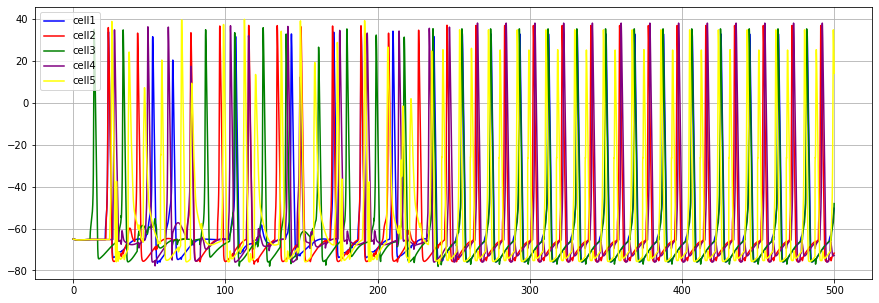

In [27]:
plt.figure(figsize=(15,5))
plt.plot(time, soma_v1, label='cell1', color='blue')
plt.plot(time, soma_v2, label='cell2', color='red')
plt.plot(time, soma_v3, label='cell3', color='green')
plt.plot(time, soma_v4, label='cell4', color='purple')
plt.plot(time, soma_v5, label='cell5', color='yellow')
plt.legend()
plt.grid(True)
plt.show()

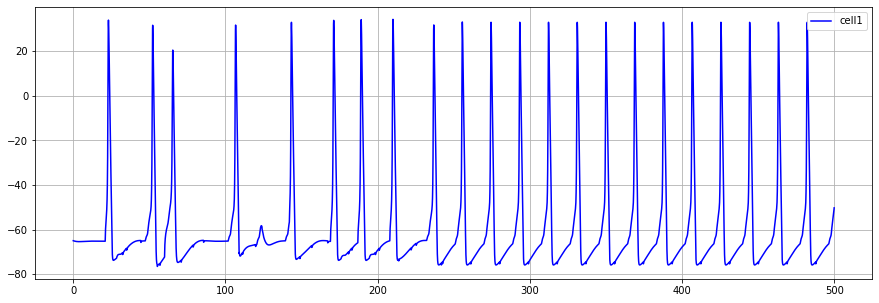

In [28]:
plt.figure(figsize=(15,5))
plt.plot(time, soma_v1, label='cell1', color='blue')
plt.legend()
plt.grid(True)
plt.show()

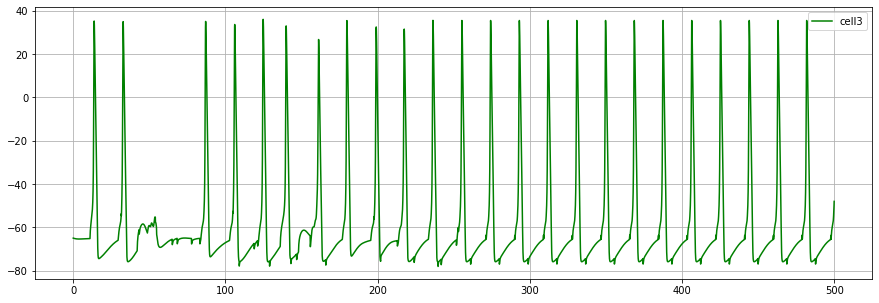

In [29]:
plt.figure(figsize=(15,5))
plt.plot(time, soma_v3, label='cell3', color='green')
plt.legend()
plt.grid(True)
plt.show()

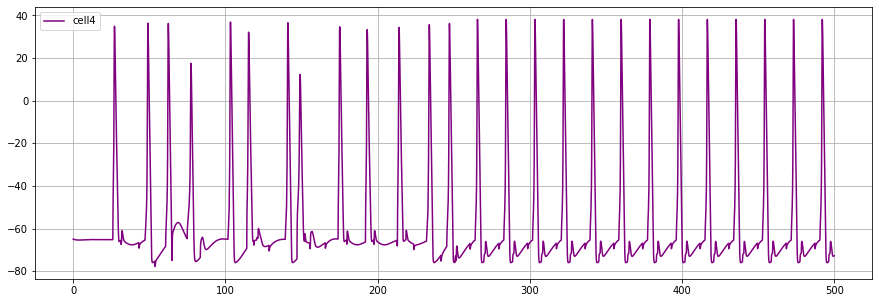

In [30]:
plt.figure(figsize=(15,5))
plt.plot(time, soma_v4, label='cell4', color='purple')
plt.legend()
plt.grid(True)
plt.show()

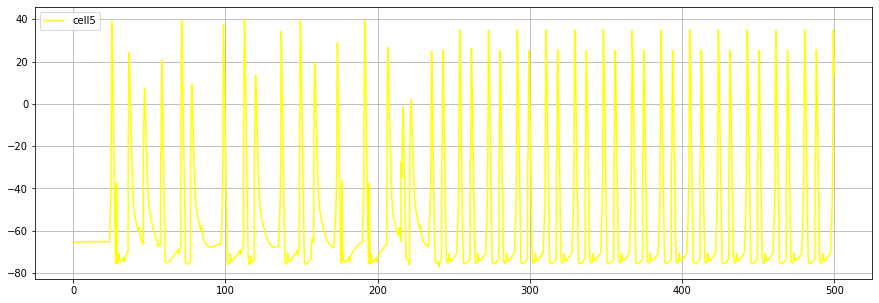

In [31]:
plt.figure(figsize=(15,5))
plt.plot(time, soma_v5, label='cell5', color='yellow')
plt.legend()
plt.grid(True)
plt.show()

In [32]:
from scipy.signal import find_peaks

def spike_detector(voltage, threshold):
    # convert Neuron recording (voltage) to list
    voltage_read = []
    for v in voltage:
        voltage_read.append(v)
    # peak locations
    spike_time, _ = find_peaks(voltage_read, height=threshold)
    return spike_time

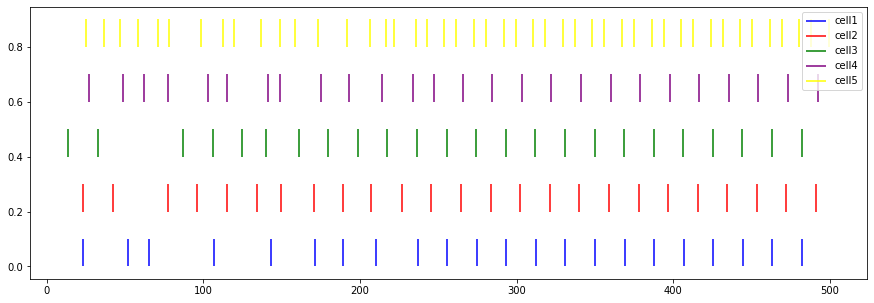

In [33]:
# You should adjust this threshold to your needs                
spikes1 = spike_detector(soma_v1, -20.0)
spikes2 = spike_detector(soma_v2, -20.0)
spikes3 = spike_detector(soma_v3, -20.0)
spikes4 = spike_detector(soma_v4, -20.0)
spikes5 = spike_detector(soma_v5, -20.0)

plt.figure(figsize=(15,5))
plt.vlines(spikes1/40, ymin=0, ymax=0.1, color='blue', label='cell1')
plt.vlines(spikes2/40, ymin=0.2, ymax=0.3, color='red', label='cell2')
plt.vlines(spikes3/40, ymin=0.4, ymax=0.5, color='green', label='cell3')
plt.vlines(spikes4/40, ymin=0.6, ymax=0.7, color='purple', label='cell4')
plt.vlines(spikes5/40, ymin=0.8, ymax=0.9, color='yellow', label='cell5')
plt.legend()

In [34]:
print("Computing interspike timing during stimulation:")
print("Pyramidal cell 1: "+str((spikes1[1] - spikes1[0])/40))
print("Pyramidal cell 2: "+str((spikes2[1] - spikes2[0])/40))
print("Pyramidal cell 3: "+str((spikes3[1] - spikes3[0])/40))
print("Inhibitory cell 1: "+str((spikes4[1] - spikes4[0])/40))
print("Inhibitory cell 2: "+str((spikes5[1] - spikes5[0])/40))


print("Computing interspike timing after stimulation:")
print("Pyramidal cell 1: "+str((spikes1[-1] - spikes1[-2])/40))
print("Pyramidal cell 2: "+str((spikes2[-1] - spikes2[-2])/40))
print("Pyramidal cell 3: "+str((spikes3[-1] - spikes3[-2])/40))
print("Inhibitory cell 1: "+str((spikes4[-1] - spikes4[-2])/40))
print("Inhibitory cell 2: "+str((spikes5[-1] - spikes5[-2])/40))

Computing interspike timing during stimulation:
Pyramidal cell 1: 29.075
Pyramidal cell 2: 19.25
Pyramidal cell 3: 19.05
Inhibitory cell 1: 21.95
Inhibitory cell 2: 11.35
Computing interspike timing after stimulation:
Pyramidal cell 1: 18.875
Pyramidal cell 2: 18.9
Pyramidal cell 3: 18.875
Inhibitory cell 1: 18.875
Inhibitory cell 2: 11.2


#### During Stimulation ISI Histogram

In [35]:
threshold = 300*40

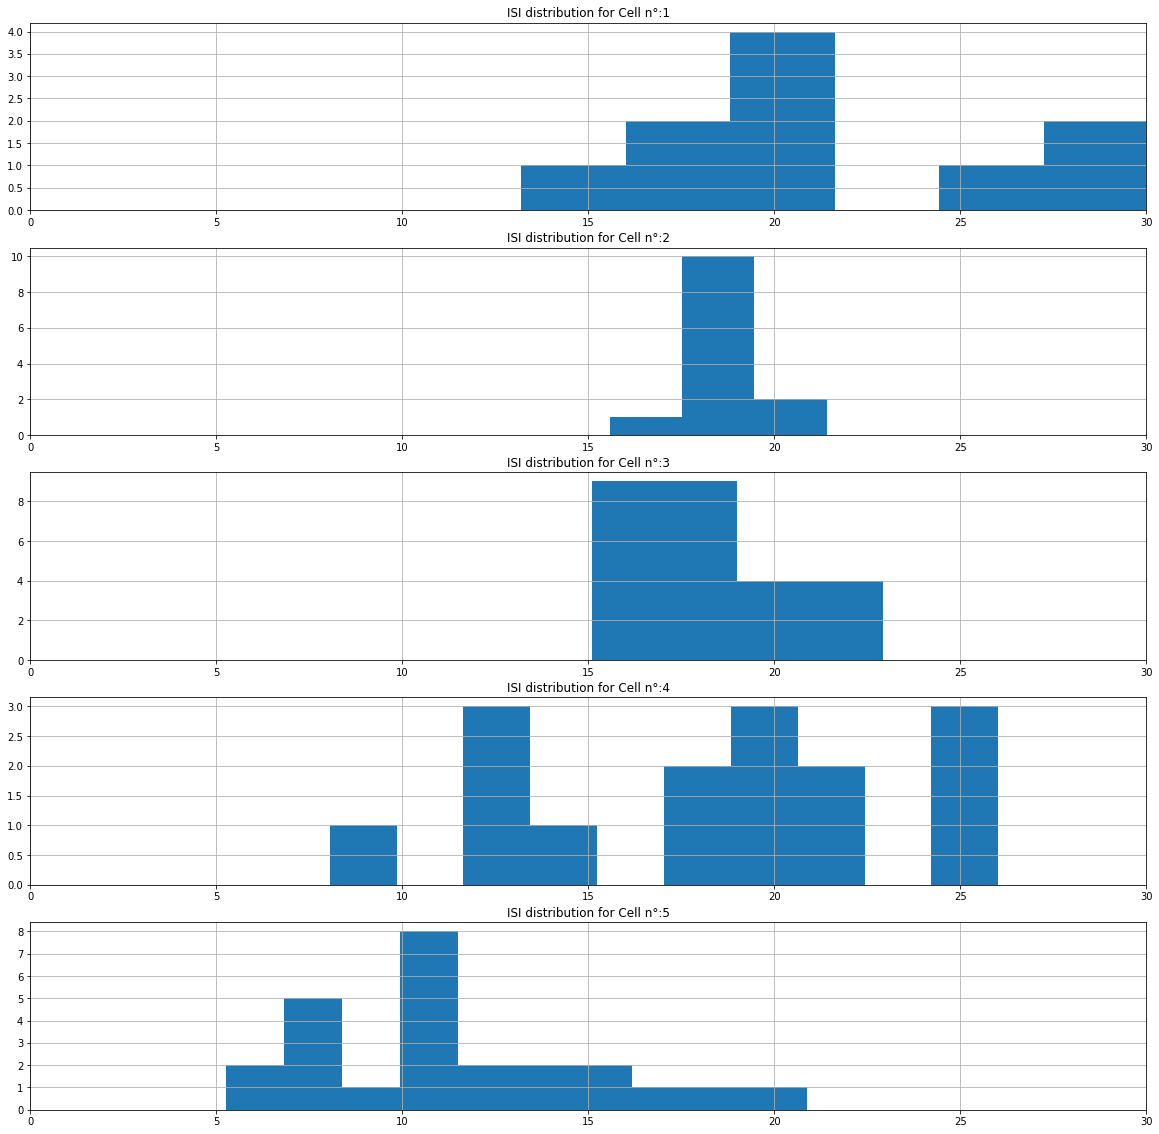

In [36]:
# Plotting the Interspike Interval distribution of the cells
all_ISI = []
ISI_1 = []
ISI_2 = []
ISI_3 = []
ISI_4 = []
ISI_5 = []

for time in range(len(spikes1)-1):
    if spikes1[time] < threshold:
        diff_time = (spikes1[time+1]-spikes1[time])/40
        ISI_1.append(diff_time)
all_ISI.append(ISI_1)

for time in range(len(spikes2)-1):
    if spikes2[time] < threshold:
        diff_time = (spikes2[time+1]-spikes2[time])/40
        ISI_2.append(diff_time)
all_ISI.append(ISI_2)
   
for time in range(len(spikes3)-1):
    if spikes3[time] < threshold:
        diff_time = (spikes3[time+1]-spikes3[time])/40
        ISI_3.append(diff_time)
all_ISI.append(ISI_3)

for time in range(len(spikes4)-1):
    if spikes4[time] < threshold:
        diff_time = (spikes4[time+1]-spikes4[time])/40
        ISI_4.append(diff_time)
all_ISI.append(ISI_4)

for time in range(len(spikes5)-1):
    if spikes5[time] < threshold:
        diff_time = (spikes5[time+1]-spikes5[time])/40
        ISI_5.append(diff_time)
all_ISI.append(ISI_5)

fig = plt.figure(figsize = (20,20))

for i in range(len(all_ISI)):
    axes = fig.add_subplot(5, 1, i+1)

    axes.hist(all_ISI[i], bins=10)
    axes.set_title("ISI distribution for Cell n°:"+str(i+1))
    axes.set_xlim([0,30])
    axes.grid(True)

#### Post Stimulation ISI Histogram

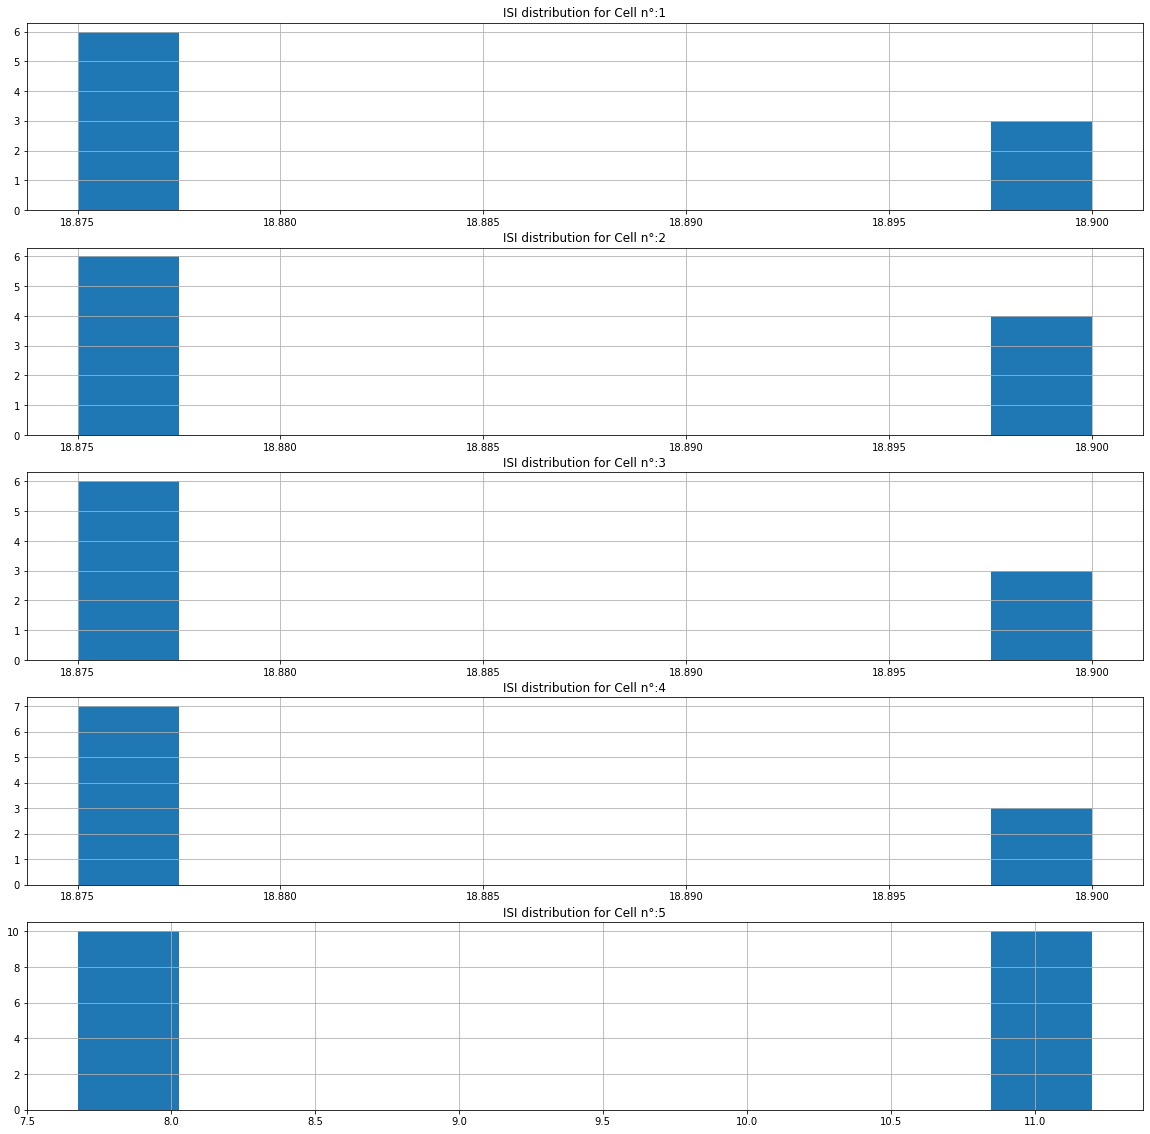

In [41]:
# Plotting the Interspike Interval distribution of the cells
all_ISI = []
ISI_1 = []
ISI_2 = []
ISI_3 = []
ISI_4 = []
ISI_5 = []

for time in range(len(spikes1)-1):
    if spikes1[time] > threshold:
        diff_time = (spikes1[time+1]-spikes1[time])/40
        ISI_1.append(diff_time)
all_ISI.append(ISI_1)

for time in range(len(spikes2)-1):
    if spikes2[time] > threshold:
        diff_time = (spikes2[time+1]-spikes2[time])/40
        ISI_2.append(diff_time)
all_ISI.append(ISI_2)
   
for time in range(len(spikes3)-1):
    if spikes3[time] > threshold:
        diff_time = (spikes3[time+1]-spikes3[time])/40
        ISI_3.append(diff_time)
all_ISI.append(ISI_3)

for time in range(len(spikes4)-1):
    if spikes4[time] > threshold:
        diff_time = (spikes4[time+1]-spikes4[time])/40
        ISI_4.append(diff_time)
all_ISI.append(ISI_4)

for time in range(len(spikes5)-1):
    if spikes5[time] > threshold:
        diff_time = (spikes5[time+1]-spikes5[time])/40
        ISI_5.append(diff_time)
all_ISI.append(ISI_5)

fig = plt.figure(figsize = (20,20))

for i in range(len(all_ISI)):
    axes = fig.add_subplot(5, 1, i+1)

    axes.hist(all_ISI[i], bins=10)
    axes.set_title("ISI distribution for Cell n°:"+str(i+1))
    #axes.set_xlim([0,30])
    axes.grid(True)

### Compare this result with the previous simulations. What is the role of the interneuron cells in this small network?

In this particular scenario, we have connected the inhibitory cells to the pyramidal cells, with a connection weight which was considerably smaller  between inhibitory neurons (w(Inh - Pyr) = -0.01 and w(Int - Int) = -0.01).

_What we observe_:
In the Raster plot obtained above, we notice that the cells do not fire regularly nor synchronously during the randomly chosen stimulation times on all 5 cells.  However, when the stimulation stops, all cells reach regular firing. When looking at the interspike interval, the values of the ISI are identical for the three pyramidal cells and the first interneuron (around 19).  The second interneuron shows ISI values which are considerably smaller (but concentrated around the values 8 and 11).  As a result, in this network, the interneurons contribute to synchronizing the cells more synchronous.

_The role of interneuron cells_:

Acording to ["From Hiring to Firing: Activation of Inhibitory Neurons and Their Recruitment in Behavior"](https://www.frontiersin.org/articles/10.3389/fnmol.2019.00168/full), a common feature of corticocortical activation of inhibitory neurons is the generation of feedforward inhibition, mediated largely by PV+ interneurons.  This feedforward inhibition can be characterized according to [this other paper](https://www.pnas.org/content/106/42/18004) as: a principal cell and an interneuron receive excitatory inputs from the same presynaptic source. The interneuron then outputs its inhibitory signal to the principal cell. Thus, upon activation of the presynaptic source, the principal cell receives 2 types of input, one excitatory and one inhibitory, separated by a brief delay due to the interneuron integration.

Moreover,  ["Many Specialists for Suppressing Cortical Excitation"](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2622740/), highlights the crucial role of inhibitory neurons in our circuit.  Indeed, the key feature of such a network in the cortex is that most of its excitatory drive is generated by local recurrent connections within cortex, whereas the connections that carry sensory inputs from the outside world are relatively sparse. This network design indicates that weak afferent inputs are amplified by local positive feedback, which selects stimulus features that resonate with response profiles represented in the strengths of recurrent excitatory connections. The potential risk of this organization is that it generates runaway excitation and limits stimulus selectivity (needed for instance in selectivity for visual motion in primary visual cortex). An effective solution to this problem is to dynamically suppress excitation by inhibition that is proportional to the overall level of activity. (which is not what we observe in our case, given that the neurons are all interconnected)

In this network however, one must note too that the connection weights with the inhibitory interneurons are considerably lower compared to the weights for pyramidal cells.  In this case, the influence of interneuron remains relatively low (see exercise 3 where we have equal weights, and the logic was similar to what we saw in course (Romani et al.), where the connection weight of inhibitory was too low to resemble biologically relevant stimulations).

# Ex3. Irregular asynchronous stimulation. Changing connection weights.

Load the five morphology reconstructions assigned to your group in week 2, using the class "Cell" defined in these tutorials and connect all cells with weight = 1. Add exponential synapses (weight 1, tau = 2 ms) to a random section of the basal dendrite of each cell. Create an irregular asynchronous stimulation and apply it to each exponential synapse. Run a simulation long enough to contain the last stimulation and plot the cells voltage response and the spikes.

1. Reduce the connection weight between your cells to 0.2, plot the same result as before and compare with the previous simulation. What do you observe ? Explain.

2. Return the connection weight between cells to its initial value of 1 and now reduce the connection weight of the expenential synapses to 0.2, plot the results and compare with the previous two simulations. What do you observe ? Is your network driven more by the stimulation or the connections between the cells. Explain [2 pts]

<span style="color:red"> Restart kernel out of precaution

In [62]:
# Importing useful libraries

%matplotlib inline

from neuron import h, gui
import matplotlib.pyplot as plt
import numpy as np
import random

random.seed(9)
np.random.seed(9)
# Load external files & initialize
h.load_file("stdrun.hoc");
h.stdinit();

### Defining the Cell class and loading the 5 morphologies

In [2]:
class Cell:
    def __init__(self, filename, name, cell_type):
        self.name = name
        self.type = cell_type
        self.synapses = []
        self.build_morphology(filename)
        self.biophysics()
        
    def build_morphology(self, filename):
        h.load_file('import3d.hoc')
        h.load_file('stdlib.hoc')
        #morph_reader = h.Import3d_Neurolucida3()
        morph_reader = h.Import3d_SWC_read()
        morph_reader.input(filename)
        i3d = h.Import3d_GUI(morph_reader, 0)
        i3d.instantiate(self) # Notice this change to be able to instantiate several cells
    
    def biophysics(self):
        for sec in h.allsec():
            sec.Ra = 100    # Axial resistance in Ohm * cm
            sec.cm = 1      # Membrane capacitance in micro Farads / cm^2
            sec.insert("pas")
            for seg in sec:
                seg.pas.g = 0.00003
                seg.pas.e = -75
        
        # Insert passive current in the dendrite
        for sec in self.soma:
            sec.insert('hh')
            for seg in sec:
                seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
                seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2
        
        if hasattr(self, 'apic'):
            for sec in self.apic:
                sec.insert('hh')
                for seg in sec:
                    seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
                    seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2
        
        for sec in self.dend:
            sec.insert('hh')
            for seg in sec:
                seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
                seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2
                
        for sec in self.axon:
            sec.insert('hh')
            for seg in sec:    
                seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
                seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2

In [3]:
Pyr1 = Cell('morph_06.swc','Pyr1','Pyr')
Pyr2 = Cell('morph_07.swc','Pyr2','Pyr')
Pyr3 = Cell('morph_09.swc','Pyr3','Pyr')
cells_Pyr = [Pyr1, Pyr2, Pyr3]
Int1 = Cell('morph_03.swc','Int1','Int')
Int2 = Cell('morph_10.swc','Int2','Int')
cells_Int = [Int1, Int2]
cells = cells_Pyr + cells_Int

error morph_06.swc line 17828: could not parse: 
error morph_07.swc line 19678: could not parse: 
error morph_09.swc line 6173: could not parse: 
error morph_03.swc line 7281: could not parse: 
error morph_10.swc line 3377: could not parse: 


In [4]:
for c in cells_Pyr:
    print('%s: %d apical sections, %d basal sections, %d soma sections and %d axon senctions' % (c.name,len(c.apic),len(c.dend), len(c.soma), len(c.axon)))
for c in cells_Int:
    print('%s: %d basal sections, %d soma sections and %d axon senctions' % (c.name,len(c.dend), len(c.soma), len(c.axon)))

Pyr1: 95 apical sections, 72 basal sections, 2 soma sections and 131 axon senctions
Pyr2: 131 apical sections, 82 basal sections, 2 soma sections and 125 axon senctions
Pyr3: 37 apical sections, 69 basal sections, 2 soma sections and 67 axon senctions
Int1: 45 basal sections, 2 soma sections and 103 axon senctions
Int2: 33 basal sections, 2 soma sections and 120 axon senctions


#### 1) Connecting all cells with weight = 1.0

In [5]:
# connect two cells with an exponential synapse at given locations
# returns the netcon
def connect(source, target, weight = None, delay = 5, source_sec = None, source_neurite = 'axon', target_sec = None, target_neurite = 'dend'):
    rng = np.random.default_rng()
    
    if weight is None:
        weight = rng.uniform() # random weight
    
    target_neurite_ = getattr(target, target_neurite)
    if target_sec is None:
        target_sec = rng.integers(0,len(target_neurite_)) # random dendritic section
    
    source_neurite_ = getattr(source, source_neurite)
    if source_sec is None:
        source_sec = rng.integers(0,len(source_neurite_)) # random axonal section
    
    target_syn = h.ExpSyn(target_neurite_[target_sec](0.5))
    target.synapses.append(target_syn) # store synapse
    
    netcon = h.NetCon(source_neurite_[source_sec](0.5)._ref_v, target_syn, sec=source_neurite_[source_sec])
    netcon.weight[0] = weight
    netcon.delay = delay
    
    print('Connected cells %s -> %s with weight %g and delay %g, from %s[%d] to %s[%d]' % (source.name,target.name,weight,delay,source_neurite,source_sec,target_neurite,target_sec))
    return netcon

In [6]:
netcons = [] # save the netcons in case we want to modify them later
chosen_weight = 1.0

# Connect Pyr2 and Pyr3 to Pyr1
nc = connect(Pyr2,Pyr1,chosen_weight)
netcons.append(nc)
nc = connect(Pyr3,Pyr1,chosen_weight)
netcons.append(nc)
nc = connect(Int1,Pyr1,weight = chosen_weight, target_neurite='soma')
netcons.append(nc)
nc = connect(Int2,Pyr1,weight = chosen_weight, target_neurite='soma')
netcons.append(nc)

# Connect Pyr1 and Pyr3 to Pyr2
nc = connect(Pyr1,Pyr2,weight = chosen_weight)
netcons.append(nc)
nc = connect(Pyr3,Pyr2,weight = chosen_weight)
netcons.append(nc)
nc = connect(Int1,Pyr2,weight = chosen_weight, target_neurite='soma')
netcons.append(nc)
nc = connect(Int2,Pyr2,weight = chosen_weight, target_neurite='soma')
netcons.append(nc)

# Connect Pyr1 and Pyr2 to Pyr3
nc = connect(Pyr1,Pyr3,weight = chosen_weight)
netcons.append(nc)
nc = connect(Pyr2,Pyr3,weight = chosen_weight)
netcons.append(nc)
nc = connect(Int1,Pyr3,weight = chosen_weight, target_neurite='soma')
netcons.append(nc)
nc = connect(Int2,Pyr3,weight = chosen_weight, target_neurite='soma')
netcons.append(nc)


# Connect Pyr1, Pyr2, Pyr3, and Int2 to Int1
nc = connect(Pyr1,Int1,weight = chosen_weight)
netcons.append(nc)
nc = connect(Pyr2,Int1,weight = chosen_weight)
netcons.append(nc)
nc = connect(Pyr3,Int1,weight = chosen_weight)
netcons.append(nc)
nc = connect(Int2,Int1,weight = chosen_weight, target_neurite='soma')
netcons.append(nc)

# Connect Pyr1, Pyr2, Pyr3, and Int1 to Int2
nc = connect(Pyr1,Int2,weight = chosen_weight)
netcons.append(nc)
nc = connect(Pyr2,Int2,weight = chosen_weight)
netcons.append(nc)
nc = connect(Pyr3,Int2,weight = chosen_weight)
netcons.append(nc)
nc = connect(Int1,Int2,weight = chosen_weight, target_neurite='soma')
netcons.append(nc)

Connected cells Pyr2 -> Pyr1 with weight 1 and delay 5, from axon[33] to dend[25]
Connected cells Pyr3 -> Pyr1 with weight 1 and delay 5, from axon[10] to dend[36]
Connected cells Int1 -> Pyr1 with weight 1 and delay 5, from axon[44] to soma[0]
Connected cells Int2 -> Pyr1 with weight 1 and delay 5, from axon[95] to soma[1]
Connected cells Pyr1 -> Pyr2 with weight 1 and delay 5, from axon[8] to dend[40]
Connected cells Pyr3 -> Pyr2 with weight 1 and delay 5, from axon[34] to dend[14]
Connected cells Int1 -> Pyr2 with weight 1 and delay 5, from axon[95] to soma[1]
Connected cells Int2 -> Pyr2 with weight 1 and delay 5, from axon[56] to soma[0]
Connected cells Pyr1 -> Pyr3 with weight 1 and delay 5, from axon[11] to dend[34]
Connected cells Pyr2 -> Pyr3 with weight 1 and delay 5, from axon[112] to dend[38]
Connected cells Int1 -> Pyr3 with weight 1 and delay 5, from axon[72] to soma[0]
Connected cells Int2 -> Pyr3 with weight 1 and delay 5, from axon[55] to soma[0]
Connected cells Pyr1 -

### Adding Exponential Synapses

In [7]:
import random
# Place exponential synapses in random cell sections
random.seed(9)
np.random.seed(9)
# Exponential synapses
# Cell 1
sec1 = random.randint(0, len(Pyr1.dend)-1)
stim_cell1 = Pyr1
synapse1 = h.ExpSyn(stim_cell1.dend[sec1](0.5))
synapse1.tau = 2 # ms
print ('Stimulus apply in basal section num %s of Pyr1' %sec1)

# Cell 2
sec2 = random.randint(0, len(Pyr2.dend)-1)
stim_cell2 = Pyr2
synapse2 = h.ExpSyn(stim_cell2.dend[sec2](0.5))
synapse2.tau = 2 # ms
print ('Stimulus apply in basal section num %s of Pyr2' %sec2)

# Cell 3
stim_cell3 = Pyr3
sec3 = random.randint(0, len(Pyr3.dend)-1)
synapse3 = h.ExpSyn(stim_cell3.dend[sec3](0.5))
synapse3.tau = 2 # ms
print ('Stimulus apply in basal section num %s of Pyr3' %sec3)

# Cell 4
stim_cell4 = Int1
sec4 = random.randint(0, len(Int1.dend)-1)
synapse4 = h.ExpSyn(stim_cell4.dend[sec4](0.5))
synapse4.tau = 2 # ms
print ('Stimulus apply in basal section num %s of Inh1' %sec4)

# Cell 5
stim_cell5 = Int2
sec5 = random.randint(0, len(Int2.dend)-1)
synapse5 = h.ExpSyn(stim_cell5.dend[sec5](0.5))
synapse5.tau = 2 # ms
print ('Stimulus apply in basal section num %s of Inh2' %sec5)

Stimulus apply in basal section num 59 of Pyr1
Stimulus apply in basal section num 78 of Pyr2
Stimulus apply in basal section num 47 of Pyr3
Stimulus apply in basal section num 17 of Inh1
Stimulus apply in basal section num 8 of Inh2


### Creating irregular asynchronous stimulation for each synapse

In [8]:
# Create random stimulation times
random.seed(9)
np.random.seed(9)
stim_times1 = [20.0]
for t in range(1, 7):
    n = random.randint(10.0,50.0)
    step = stim_times1[t-1] + n
    stim_times1.append(step)

stim_times2 = [30.0]
for t in range(1, 7):
    n = random.randint(10.0,50.0)
    step = stim_times2[t-1] + n
    stim_times2.append(step)

stim_times3 = [10.0]
for t in range(1, 7):
    n = random.randint(10.0,50.0)
    step = stim_times3[t-1] + n
    stim_times3.append(step)

stim_times4 = [20.0]
for t in range(1, 7):
    n = random.randint(10.0,50.0)
    step = stim_times4[t-1] + n
    stim_times4.append(step)


stim_times5 = [30.0]
for t in range(1, 7):
    n = random.randint(10.0,50.0)
    step = stim_times5[t-1] + n
    stim_times5.append(step)

# Check what is the output
print('stimulation interval 1 = %s' %stim_times1)
print('stimulation interval 2 = %s' %stim_times2)
print('stimulation interval 3 = %s' %stim_times3)
print('stimulation interval 4 = %s' %stim_times4)
print('stimulation interval 5 = %s' %stim_times5)

stimulation interval 1 = [20.0, 59.0, 108.0, 141.0, 168.0, 186.0, 207.0]
stimulation interval 2 = [30.0, 40.0, 71.0, 113.0, 152.0, 200.0, 215.0]
stimulation interval 3 = [10.0, 41.0, 86.0, 135.0, 147.0, 181.0, 201.0]
stimulation interval 4 = [20.0, 58.0, 95.0, 115.0, 135.0, 160.0, 173.0]
stimulation interval 5 = [30.0, 47.0, 65.0, 107.0, 154.0, 168.0, 202.0]


In [9]:
# Stimulator
stimulator1 = h.VecStim()
spike_times1 = stim_times1
spikes_vector1 = h.Vector(spike_times1)
stimulator1.play(spikes_vector1)

stimulator2 = h.VecStim()
spike_times2 = stim_times2
spikes_vector2 = h.Vector(spike_times2)
stimulator2.play(spikes_vector2)

stimulator3 = h.VecStim()
spike_times3 = stim_times3
spikes_vector3 = h.Vector(spike_times3)
stimulator3.play(spikes_vector3)

stimulator4 = h.VecStim()
spike_times4 = stim_times4
spikes_vector4 = h.Vector(spike_times4)
stimulator4.play(spikes_vector4)

stimulator5 = h.VecStim()
spike_times5 = stim_times5
spikes_vector5 = h.Vector(spike_times5)
stimulator5.play(spikes_vector5)

connection_weight = 1.0

connection1 = h.NetCon(stimulator1, synapse1)
connection1.weight[0] = connection_weight        # In units of [nS] due to the gmax scaling factor in our .mod file
connection2 = h.NetCon(stimulator2, synapse2)
connection2.weight[0] = connection_weight        # In units of [nS] due to the gmax scaling factor in our .mod file
connection3 = h.NetCon(stimulator3, synapse3)
connection3.weight[0] = connection_weight        # In units of [nS] due to the gmax scaling factor in our .mod file
connection4 = h.NetCon(stimulator4, synapse4)
connection4.weight[0] = connection_weight        # In units of [nS] due to the gmax scaling factor in our .mod file
connection5 = h.NetCon(stimulator5, synapse5)
connection5.weight[0] = connection_weight        # In units of [nS] due to the gmax scaling factor in our .mod file

### Running a simulation that lasts at least part of stimulation and plotting cell voltage response and spikes

In [10]:
recording_cell1 = Pyr1
recording_cell2 = Pyr2
recording_cell3 = Pyr3
recording_cell4 = Int1
recording_cell5 = Int2

soma_v1 = h.Vector().record(recording_cell1.soma[0](0.5)._ref_v)
soma_v2 = h.Vector().record(recording_cell2.soma[0](0.5)._ref_v)
soma_v3 = h.Vector().record(recording_cell3.soma[0](0.5)._ref_v)
soma_v4 = h.Vector().record(recording_cell4.soma[0](0.5)._ref_v)
soma_v5 = h.Vector().record(recording_cell5.soma[0](0.5)._ref_v)

time = h.Vector().record(h._ref_t)

h.finitialize(-65)
h.continuerun(500)

0.0

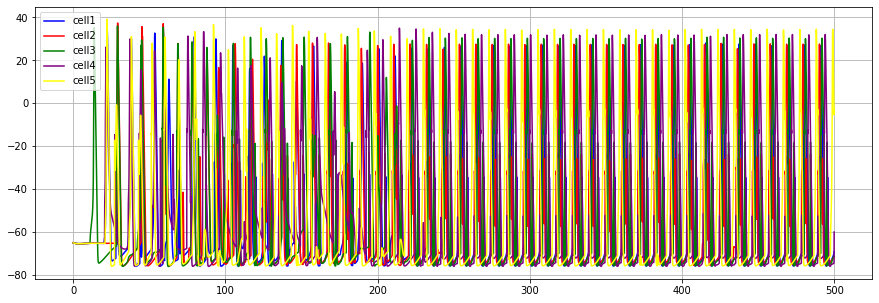

In [12]:
plt.figure(figsize=(15,5))
plt.plot(time, soma_v1, label='cell1', color='blue')
plt.plot(time, soma_v2, label='cell2', color='red')
plt.plot(time, soma_v3, label='cell3', color='green')
plt.plot(time, soma_v4, label='cell4', color='purple')
plt.plot(time, soma_v5, label='cell5', color='yellow')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
from scipy.signal import find_peaks

def spike_detector(voltage, threshold):
    # convert Neuron recording (voltage) to list
    voltage_read = []
    for v in voltage:
        voltage_read.append(v)
    # peak locations
    spike_time, _ = find_peaks(voltage_read, height=threshold)
    return spike_time

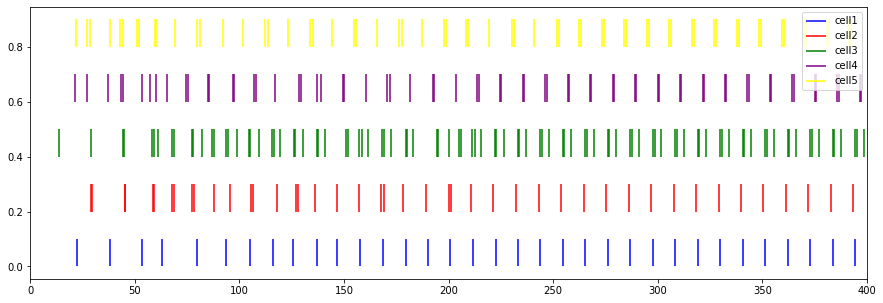

In [14]:
spikes1 = spike_detector(soma_v1, -20.0)
spikes2 = spike_detector(soma_v2, -20.0)
spikes3 = spike_detector(soma_v3, -20.0)
spikes4 = spike_detector(soma_v4, -20.0)
spikes5 = spike_detector(soma_v5, -20.0)

plt.figure(figsize=(15,5))
plt.vlines(spikes1/40, ymin=0, ymax=0.1, color='blue', label='cell1')
plt.vlines(spikes2/40, ymin=0.2, ymax=0.3, color='red', label='cell2')
plt.vlines(spikes3/40, ymin=0.4, ymax=0.5, color='green', label='cell3')
plt.vlines(spikes4/40, ymin=0.6, ymax=0.7, color='purple', label='cell4')
plt.vlines(spikes5/40, ymin=0.8, ymax=0.9, color='yellow', label='cell5')
plt.xlim((0, 400))
plt.legend()

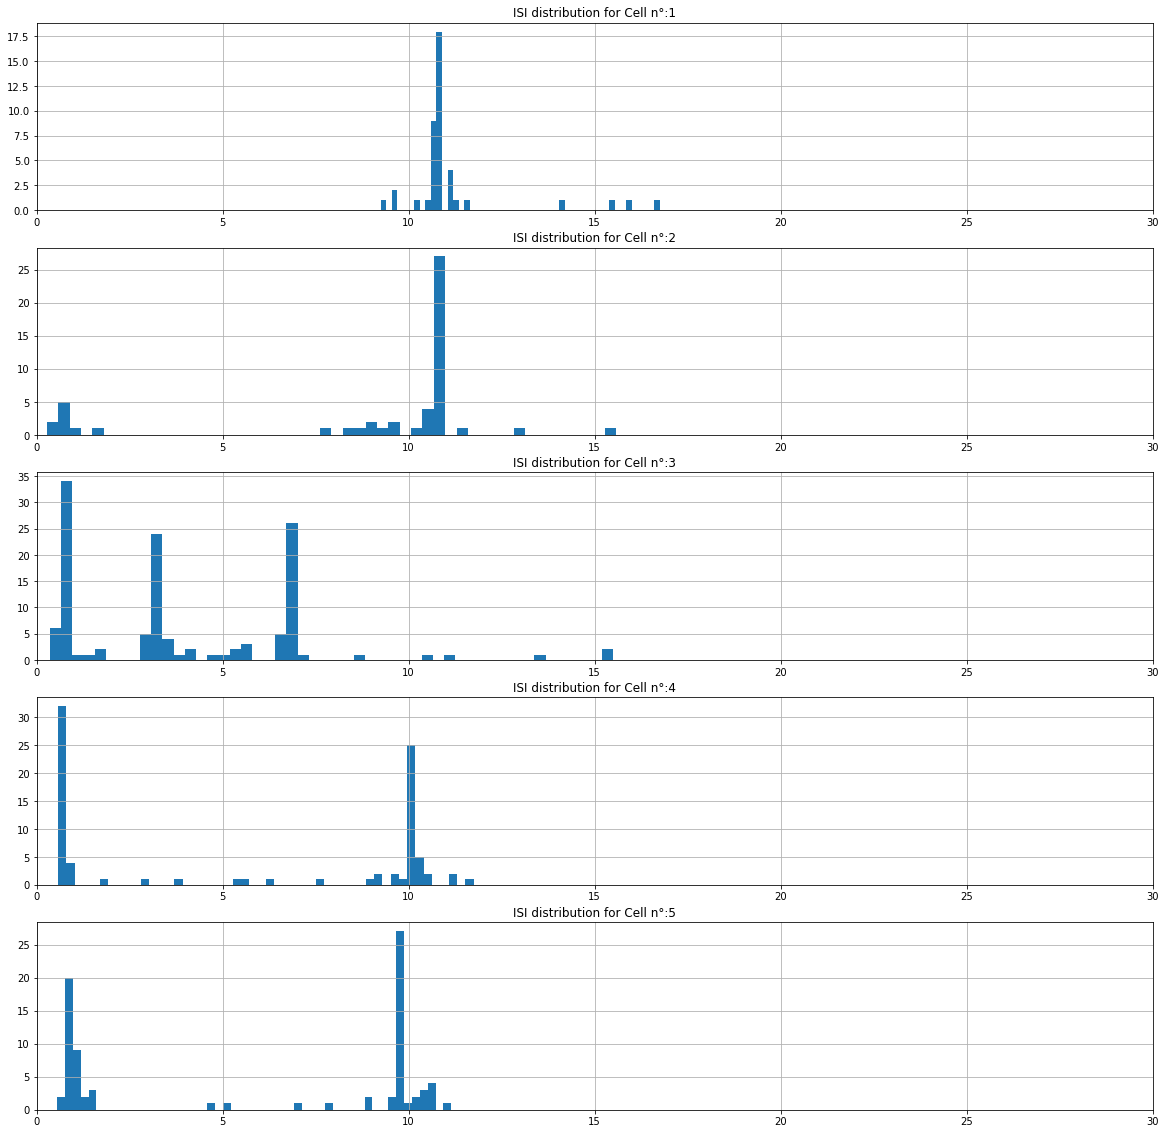

In [16]:
# Plotting the Interspike Interval distribution of the cells
all_ISI = []
ISI_1 = []
ISI_2 = []
ISI_3 = []
ISI_4 = []
ISI_5 = []

for time in range(len(spikes1)-1):
    if spikes1[time] > 300:
        diff_time = (spikes1[time+1]-spikes1[time])/40
        ISI_1.append(diff_time)
all_ISI.append(ISI_1)

for time in range(len(spikes2)-1):
    if spikes2[time] > 300:
        diff_time = (spikes2[time+1]-spikes2[time])/40
        ISI_2.append(diff_time)
all_ISI.append(ISI_2)
   
for time in range(len(spikes3)-1):
    if spikes3[time] > 300:
        diff_time = (spikes3[time+1]-spikes3[time])/40
        ISI_3.append(diff_time)
all_ISI.append(ISI_3)

for time in range(len(spikes4)-1):
    if spikes4[time] > 300:
        diff_time = (spikes4[time+1]-spikes4[time])/40
        ISI_4.append(diff_time)
all_ISI.append(ISI_4)

for time in range(len(spikes5)-1):
    if spikes5[time] > 300:
        diff_time = (spikes5[time+1]-spikes5[time])/40
        ISI_5.append(diff_time)
all_ISI.append(ISI_5)

fig = plt.figure(figsize = (20,20))

for i in range(len(all_ISI)):
    axes = fig.add_subplot(5, 1, i+1)

    axes.hist(all_ISI[i], bins=50)
    axes.set_title("ISI distribution for Cell n°:"+str(i+1))
    axes.set_xlim([0,30])
    axes.grid(True)

#### Conclusion 1:
As illustrated above, one can see that all neurons have reached regular firing behavior and this is evident in the ISI histograms that was measured after the stimultion ended (after 300 ms) which show a high number of interspike intervals with the same value.

Moreover, whereas pyramidal cell 1 and 2 reach regular firing and appear to be synchronous, pyramidal cell 3 has a firing frequency which has considerably increased and shows much smaller interspike intervals (see distribution after the stimulation has ended).  As for the interneurons, they seem to show two predominant values of interspike intervals which are roughly the same between these two inhibitory cells.

###  ___Question 1___: Reduce the connection weight between your cells to 0.2, plot the same result as before and compare with the previous simulation. What do you observe ? Explain.

#### 2) Reducing the connection weight between the cells to 0.2

In [17]:
netcons = [] # save the netcons in case we want to modify them later
chosen_weight = 0.2

# Connect Pyr2 and Pyr3 to Pyr1
nc = connect(Pyr2,Pyr1,chosen_weight)
netcons.append(nc)
nc = connect(Pyr3,Pyr1,chosen_weight)
netcons.append(nc)
nc = connect(Int1,Pyr1,weight = chosen_weight, target_neurite='soma')
netcons.append(nc)
nc = connect(Int2,Pyr1,weight = chosen_weight, target_neurite='soma')
netcons.append(nc)

# Connect Pyr1 and Pyr3 to Pyr2
nc = connect(Pyr1,Pyr2,weight = chosen_weight)
netcons.append(nc)
nc = connect(Pyr3,Pyr2,weight = chosen_weight)
netcons.append(nc)
nc = connect(Int1,Pyr2,weight = chosen_weight, target_neurite='soma')
netcons.append(nc)
nc = connect(Int2,Pyr2,weight = chosen_weight, target_neurite='soma')
netcons.append(nc)

# Connect Pyr1 and Pyr2 to Pyr3
nc = connect(Pyr1,Pyr3,weight = chosen_weight)
netcons.append(nc)
nc = connect(Pyr2,Pyr3,weight = chosen_weight)
netcons.append(nc)
nc = connect(Int1,Pyr3,weight = chosen_weight, target_neurite='soma')
netcons.append(nc)
nc = connect(Int2,Pyr3,weight = chosen_weight, target_neurite='soma')
netcons.append(nc)


# Connect Pyr1, Pyr2, Pyr3, and Int2 to Int1
nc = connect(Pyr1,Int1,weight = chosen_weight)
netcons.append(nc)
nc = connect(Pyr2,Int1,weight = chosen_weight)
netcons.append(nc)
nc = connect(Pyr3,Int1,weight = chosen_weight)
netcons.append(nc)
nc = connect(Int2,Int1,weight = chosen_weight, target_neurite='soma')
netcons.append(nc)

# Connect Pyr1, Pyr2, Pyr3, and Int1 to Int2
nc = connect(Pyr1,Int2,weight = chosen_weight)
netcons.append(nc)
nc = connect(Pyr2,Int2,weight = chosen_weight)
netcons.append(nc)
nc = connect(Pyr3,Int2,weight = chosen_weight)
netcons.append(nc)
nc = connect(Int1,Int2,weight = chosen_weight, target_neurite='soma')
netcons.append(nc)

Connected cells Pyr2 -> Pyr1 with weight 0.2 and delay 5, from axon[69] to dend[58]
Connected cells Pyr3 -> Pyr1 with weight 0.2 and delay 5, from axon[49] to dend[46]
Connected cells Int1 -> Pyr1 with weight 0.2 and delay 5, from axon[66] to soma[1]
Connected cells Int2 -> Pyr1 with weight 0.2 and delay 5, from axon[77] to soma[1]
Connected cells Pyr1 -> Pyr2 with weight 0.2 and delay 5, from axon[82] to dend[66]
Connected cells Pyr3 -> Pyr2 with weight 0.2 and delay 5, from axon[27] to dend[67]
Connected cells Int1 -> Pyr2 with weight 0.2 and delay 5, from axon[97] to soma[0]
Connected cells Int2 -> Pyr2 with weight 0.2 and delay 5, from axon[11] to soma[0]
Connected cells Pyr1 -> Pyr3 with weight 0.2 and delay 5, from axon[31] to dend[50]
Connected cells Pyr2 -> Pyr3 with weight 0.2 and delay 5, from axon[50] to dend[61]
Connected cells Int1 -> Pyr3 with weight 0.2 and delay 5, from axon[35] to soma[1]
Connected cells Int2 -> Pyr3 with weight 0.2 and delay 5, from axon[50] to soma[1

In [18]:
# Adding the exponential synapses in the same places as previously chosen
random.seed(9)
np.random.seed(9)
# Cell 1
synapse1 = h.ExpSyn(stim_cell1.dend[sec1](0.5))
synapse1.tau = 2 # ms
print ('Stimulus apply in basal section num %s of Pyr1' %sec1)

# Cell 2
synapse2 = h.ExpSyn(stim_cell2.dend[sec2](0.5))
synapse2.tau = 2 # ms
print ('Stimulus apply in basal section num %s of Pyr2' %sec2)

# Cell 3
synapse3 = h.ExpSyn(stim_cell3.dend[sec3](0.5))
synapse3.tau = 2 # ms
print ('Stimulus apply in basal section num %s of Pyr3' %sec3)

# Cell 4
synapse4 = h.ExpSyn(stim_cell4.dend[sec4](0.5))
synapse4.tau = 2 # ms
print ('Stimulus apply in basal section num %s of Inh1' %sec4)

# Cell 5
stim_cell5 = Int2
sec5 = random.randint(0, len(Int2.dend)-1)
synapse5 = h.ExpSyn(stim_cell5.dend[sec5](0.5))
synapse5.tau = 2 # ms
print ('Stimulus apply in basal section num %s of Inh2' %sec5)

Stimulus apply in basal section num 59 of Pyr1
Stimulus apply in basal section num 78 of Pyr2
Stimulus apply in basal section num 47 of Pyr3
Stimulus apply in basal section num 17 of Inh1
Stimulus apply in basal section num 29 of Inh2


In [19]:
# Stimulator
stimulator1 = h.VecStim()
spike_times1 = stim_times1
spikes_vector1 = h.Vector(spike_times1)
stimulator1.play(spikes_vector1)

stimulator2 = h.VecStim()
spike_times2 = stim_times2
spikes_vector2 = h.Vector(spike_times2)
stimulator2.play(spikes_vector2)

stimulator3 = h.VecStim()
spike_times3 = stim_times3
spikes_vector3 = h.Vector(spike_times3)
stimulator3.play(spikes_vector3)

stimulator4 = h.VecStim()
spike_times4 = stim_times4
spikes_vector4 = h.Vector(spike_times4)
stimulator4.play(spikes_vector4)

stimulator5 = h.VecStim()
spike_times5 = stim_times5
spikes_vector5 = h.Vector(spike_times5)
stimulator5.play(spikes_vector5)

connection_weight = 1.0

connection1 = h.NetCon(stimulator1, synapse1)
connection1.weight[0] = connection_weight        # In units of [nS] due to the gmax scaling factor in our .mod file
connection2 = h.NetCon(stimulator2, synapse2)
connection2.weight[0] = connection_weight        # In units of [nS] due to the gmax scaling factor in our .mod file
connection3 = h.NetCon(stimulator3, synapse3)
connection3.weight[0] = connection_weight        # In units of [nS] due to the gmax scaling factor in our .mod file
connection4 = h.NetCon(stimulator4, synapse4)
connection4.weight[0] = connection_weight        # In units of [nS] due to the gmax scaling factor in our .mod file
connection5 = h.NetCon(stimulator5, synapse5)
connection5.weight[0] = connection_weight        # In units of [nS] due to the gmax scaling factor in our .mod file

In [20]:
recording_cell1 = Pyr1
recording_cell2 = Pyr2
recording_cell3 = Pyr3
recording_cell4 = Int1
recording_cell5 = Int2

soma_v1 = h.Vector().record(recording_cell1.soma[0](0.5)._ref_v)
soma_v2 = h.Vector().record(recording_cell2.soma[0](0.5)._ref_v)
soma_v3 = h.Vector().record(recording_cell3.soma[0](0.5)._ref_v)
soma_v4 = h.Vector().record(recording_cell4.soma[0](0.5)._ref_v)
soma_v5 = h.Vector().record(recording_cell5.soma[0](0.5)._ref_v)

time = h.Vector().record(h._ref_t)

h.finitialize(-65)
h.continuerun(500)

0.0

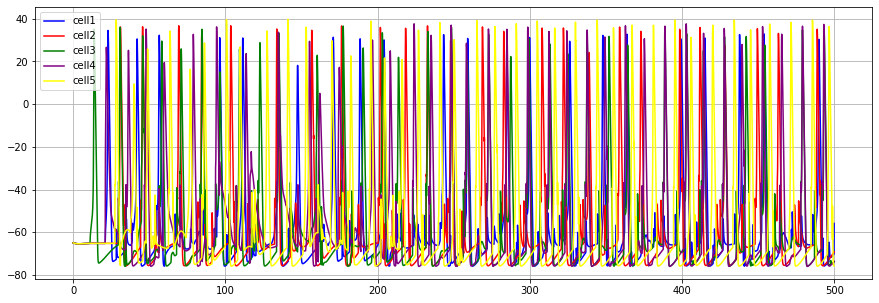

In [21]:
plt.figure(figsize=(15,5))
plt.plot(time, soma_v1, label='cell1', color='blue')
plt.plot(time, soma_v2, label='cell2', color='red')
plt.plot(time, soma_v3, label='cell3', color='green')
plt.plot(time, soma_v4, label='cell4', color='purple')
plt.plot(time, soma_v5, label='cell5', color='yellow')
plt.legend()
plt.grid(True)
plt.show()

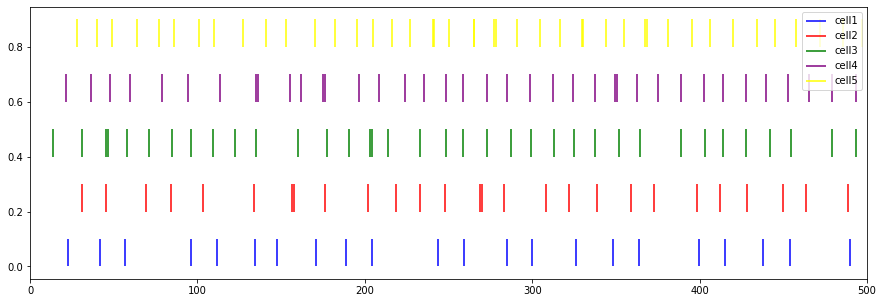

In [22]:
spikes1 = spike_detector(soma_v1, -20.0)
spikes2 = spike_detector(soma_v2, -20.0)
spikes3 = spike_detector(soma_v3, -20.0)
spikes4 = spike_detector(soma_v4, -20.0)
spikes5 = spike_detector(soma_v5, -20.0)

plt.figure(figsize=(15,5))
plt.vlines(spikes1/40, ymin=0, ymax=0.1, color='blue', label='cell1')
plt.vlines(spikes2/40, ymin=0.2, ymax=0.3, color='red', label='cell2')
plt.vlines(spikes3/40, ymin=0.4, ymax=0.5, color='green', label='cell3')
plt.vlines(spikes4/40, ymin=0.6, ymax=0.7, color='purple', label='cell4')
plt.vlines(spikes5/40, ymin=0.8, ymax=0.9, color='yellow', label='cell5')
plt.xlim((0, 500))
plt.legend()

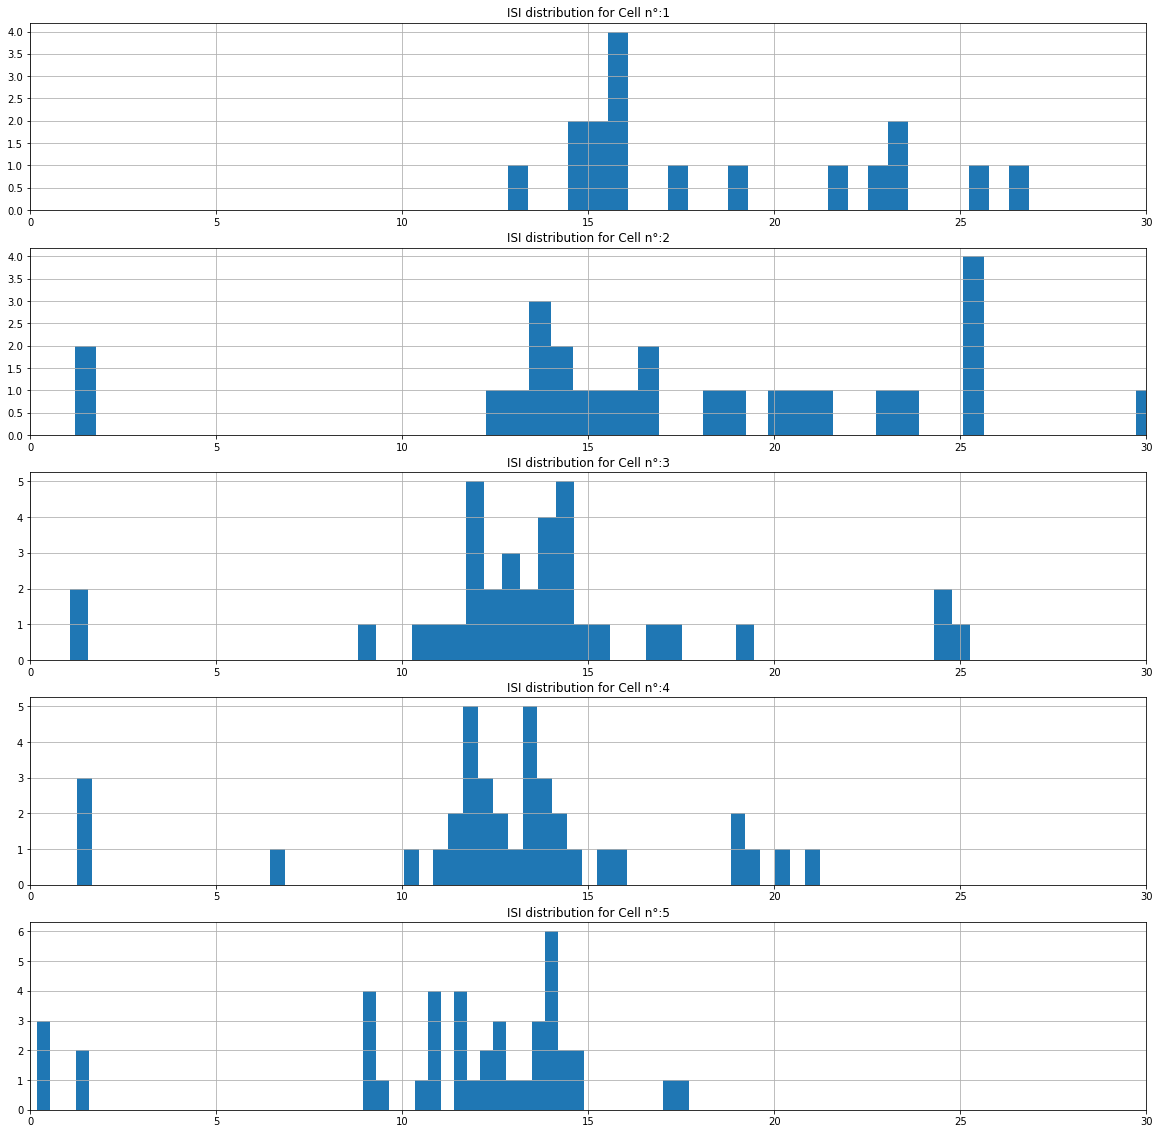

In [23]:
# Plotting the Interspike Interval distribution of the cells
all_ISI = []
ISI_1 = []
ISI_2 = []
ISI_3 = []
ISI_4 = []
ISI_5 = []

for time in range(len(spikes1)-1):
    if spikes1[time] > 300:
        diff_time = (spikes1[time+1]-spikes1[time])/40
        ISI_1.append(diff_time)
all_ISI.append(ISI_1)

for time in range(len(spikes2)-1):
    if spikes2[time] > 300:
        diff_time = (spikes2[time+1]-spikes2[time])/40
        ISI_2.append(diff_time)
all_ISI.append(ISI_2)
   
for time in range(len(spikes3)-1):
    if spikes3[time] > 300:
        diff_time = (spikes3[time+1]-spikes3[time])/40
        ISI_3.append(diff_time)
all_ISI.append(ISI_3)

for time in range(len(spikes4)-1):
    if spikes4[time] > 300:
        diff_time = (spikes4[time+1]-spikes4[time])/40
        ISI_4.append(diff_time)
all_ISI.append(ISI_4)

for time in range(len(spikes5)-1):
    if spikes5[time] > 300:
        diff_time = (spikes5[time+1]-spikes5[time])/40
        ISI_5.append(diff_time)
all_ISI.append(ISI_5)

fig = plt.figure(figsize = (20,20))

for i in range(len(all_ISI)):
    axes = fig.add_subplot(5, 1, i+1)

    axes.hist(all_ISI[i], bins=50)
    axes.set_title("ISI distribution for Cell n°:"+str(i+1))
    axes.set_xlim([0,30])
    axes.grid(True)

##### --> Explain what is observed when reducing connection weight between cells to 0.2

#### Conclusion 2:
As showcased above, it is substantially evident that the neurons are firing in an irregular and asynchronous pattern.  Moreover, the irregularity of the interspike interval can be noted in the distribution plots, where the values of the interspike intervals are much more broadly distributed, and their mean value has increased (the spikes are sparser than in the previous case). Thus, one can say that this aforementioned phenomenon is due to the decrease in weights between the cells (from 1 to 0.2).

### ___Question 2___: Return the connection weight between cells to its initial value of 1 and now reduce the connection weight of the exponential synapses to 0.2, plot the results and compare with the previous two simulations. What do you observe ? Is your network driven more by the stimulation or the connections between the cells. Explain

#### 3) Reduce the connection weight of the exponential synapses to 0.2

In [24]:
# Returning the connection weight between cells to its intial value of 1

netcons = [] # save the netcons in case we want to modify them later
chosen_weight = 1.0

# Connect Pyr2 and Pyr3 to Pyr1
nc = connect(Pyr2,Pyr1,chosen_weight)
netcons.append(nc)
nc = connect(Pyr3,Pyr1,chosen_weight)
netcons.append(nc)
nc = connect(Int1,Pyr1,weight = chosen_weight, target_neurite='soma')
netcons.append(nc)
nc = connect(Int2,Pyr1,weight = chosen_weight, target_neurite='soma')
netcons.append(nc)

# Connect Pyr1 and Pyr3 to Pyr2
nc = connect(Pyr1,Pyr2,weight = chosen_weight)
netcons.append(nc)
nc = connect(Pyr3,Pyr2,weight = chosen_weight)
netcons.append(nc)
nc = connect(Int1,Pyr2,weight = chosen_weight, target_neurite='soma')
netcons.append(nc)
nc = connect(Int2,Pyr2,weight = chosen_weight, target_neurite='soma')
netcons.append(nc)

# Connect Pyr1 and Pyr2 to Pyr3
nc = connect(Pyr1,Pyr3,weight = chosen_weight)
netcons.append(nc)
nc = connect(Pyr2,Pyr3,weight = chosen_weight)
netcons.append(nc)
nc = connect(Int1,Pyr3,weight = chosen_weight, target_neurite='soma')
netcons.append(nc)
nc = connect(Int2,Pyr3,weight = chosen_weight, target_neurite='soma')
netcons.append(nc)


# Connect Pyr1, Pyr2, Pyr3, and Int2 to Int1
nc = connect(Pyr1,Int1,weight = chosen_weight)
netcons.append(nc)
nc = connect(Pyr2,Int1,weight = chosen_weight)
netcons.append(nc)
nc = connect(Pyr3,Int1,weight = chosen_weight)
netcons.append(nc)
nc = connect(Int2,Int1,weight = chosen_weight, target_neurite='soma')
netcons.append(nc)

# Connect Pyr1, Pyr2, Pyr3, and Int1 to Int2
nc = connect(Pyr1,Int2,weight = chosen_weight)
netcons.append(nc)
nc = connect(Pyr2,Int2,weight = chosen_weight)
netcons.append(nc)
nc = connect(Pyr3,Int2,weight = chosen_weight)
netcons.append(nc)
nc = connect(Int1,Int2,weight = chosen_weight, target_neurite='soma')
netcons.append(nc)

Connected cells Pyr2 -> Pyr1 with weight 1 and delay 5, from axon[43] to dend[34]
Connected cells Pyr3 -> Pyr1 with weight 1 and delay 5, from axon[17] to dend[27]
Connected cells Int1 -> Pyr1 with weight 1 and delay 5, from axon[85] to soma[0]
Connected cells Int2 -> Pyr1 with weight 1 and delay 5, from axon[76] to soma[0]
Connected cells Pyr1 -> Pyr2 with weight 1 and delay 5, from axon[126] to dend[71]
Connected cells Pyr3 -> Pyr2 with weight 1 and delay 5, from axon[24] to dend[40]
Connected cells Int1 -> Pyr2 with weight 1 and delay 5, from axon[80] to soma[0]
Connected cells Int2 -> Pyr2 with weight 1 and delay 5, from axon[89] to soma[0]
Connected cells Pyr1 -> Pyr3 with weight 1 and delay 5, from axon[32] to dend[0]
Connected cells Pyr2 -> Pyr3 with weight 1 and delay 5, from axon[112] to dend[15]
Connected cells Int1 -> Pyr3 with weight 1 and delay 5, from axon[14] to soma[0]
Connected cells Int2 -> Pyr3 with weight 1 and delay 5, from axon[97] to soma[1]
Connected cells Pyr1 

In [25]:
# Adding the exponential synapses in the same places as previously chosen
random.seed(9)
np.random.seed(9)

# Cell 1
synapse1 = h.ExpSyn(stim_cell1.dend[sec1](0.5))
synapse1.tau = 2 # ms
print ('Stimulus apply in basal section num %s of Pyr1' %sec1)

# Cell 2
synapse2 = h.ExpSyn(stim_cell2.dend[sec2](0.5))
synapse2.tau = 2 # ms
print ('Stimulus apply in basal section num %s of Pyr2' %sec2)

# Cell 3
synapse3 = h.ExpSyn(stim_cell3.dend[sec3](0.5))
synapse3.tau = 2 # ms
print ('Stimulus apply in basal section num %s of Pyr3' %sec3)

# Cell 4
synapse4 = h.ExpSyn(stim_cell4.dend[sec4](0.5))
synapse4.tau = 2 # ms
print ('Stimulus apply in basal section num %s of Inh1' %sec4)

# Cell 5
stim_cell5 = Int2
sec5 = random.randint(0, len(Int2.dend)-1)
synapse5 = h.ExpSyn(stim_cell5.dend[sec5](0.5))
synapse5.tau = 2 # ms
print ('Stimulus apply in basal section num %s of Inh2' %sec5)

Stimulus apply in basal section num 59 of Pyr1
Stimulus apply in basal section num 78 of Pyr2
Stimulus apply in basal section num 47 of Pyr3
Stimulus apply in basal section num 17 of Inh1
Stimulus apply in basal section num 29 of Inh2


In [26]:
# Stimulator
stimulator1 = h.VecStim()
spike_times1 = stim_times1
spikes_vector1 = h.Vector(spike_times1)
stimulator1.play(spikes_vector1)

stimulator2 = h.VecStim()
spike_times2 = stim_times2
spikes_vector2 = h.Vector(spike_times2)
stimulator2.play(spikes_vector2)

stimulator3 = h.VecStim()
spike_times3 = stim_times3
spikes_vector3 = h.Vector(spike_times3)
stimulator3.play(spikes_vector3)

stimulator4 = h.VecStim()
spike_times4 = stim_times4
spikes_vector4 = h.Vector(spike_times4)
stimulator4.play(spikes_vector4)

stimulator5 = h.VecStim()
spike_times5 = stim_times5
spikes_vector5 = h.Vector(spike_times5)
stimulator5.play(spikes_vector5)

connection_weight = 0.2

connection1 = h.NetCon(stimulator1, synapse1)
connection1.weight[0] = connection_weight        # In units of [nS] due to the gmax scaling factor in our .mod file
connection2 = h.NetCon(stimulator2, synapse2)
connection2.weight[0] = connection_weight        # In units of [nS] due to the gmax scaling factor in our .mod file
connection3 = h.NetCon(stimulator3, synapse3)
connection3.weight[0] = connection_weight        # In units of [nS] due to the gmax scaling factor in our .mod file
connection4 = h.NetCon(stimulator4, synapse4)
connection4.weight[0] = connection_weight        # In units of [nS] due to the gmax scaling factor in our .mod file
connection5 = h.NetCon(stimulator5, synapse5)
connection5.weight[0] = connection_weight        # In units of [nS] due to the gmax scaling factor in our .mod file

In [27]:
recording_cell1 = Pyr1
recording_cell2 = Pyr2
recording_cell3 = Pyr3
recording_cell4 = Int1
recording_cell5 = Int2

soma_v1 = h.Vector().record(recording_cell1.soma[0](0.5)._ref_v)
soma_v2 = h.Vector().record(recording_cell2.soma[0](0.5)._ref_v)
soma_v3 = h.Vector().record(recording_cell3.soma[0](0.5)._ref_v)
soma_v4 = h.Vector().record(recording_cell4.soma[0](0.5)._ref_v)
soma_v5 = h.Vector().record(recording_cell5.soma[0](0.5)._ref_v)

time = h.Vector().record(h._ref_t)

h.finitialize(-65)
h.continuerun(500)

0.0

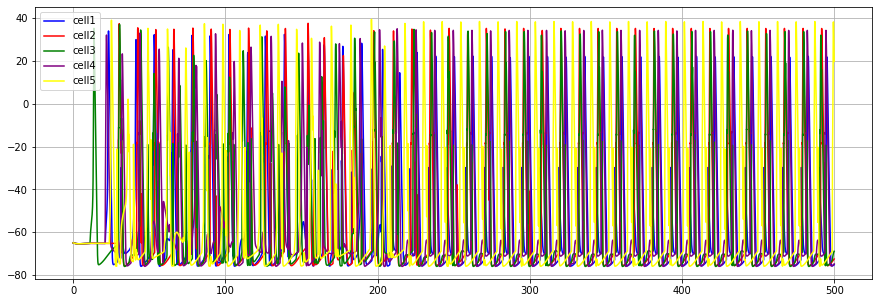

In [28]:
plt.figure(figsize=(15,5))
plt.plot(time, soma_v1, label='cell1', color='blue')
plt.plot(time, soma_v2, label='cell2', color='red')
plt.plot(time, soma_v3, label='cell3', color='green')
plt.plot(time, soma_v4, label='cell4', color='purple')
plt.plot(time, soma_v5, label='cell5', color='yellow')
plt.legend()
plt.grid(True)
plt.show()

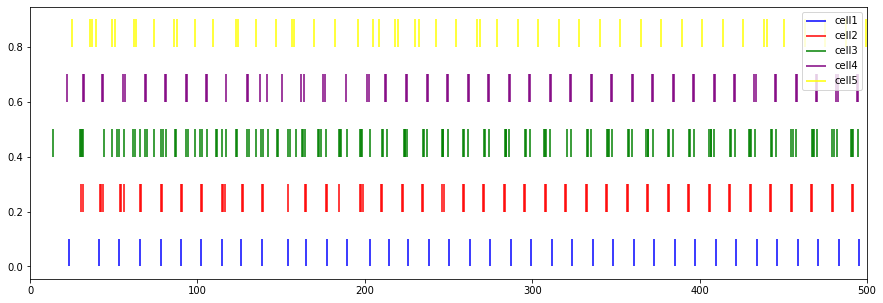

In [29]:
spikes1 = spike_detector(soma_v1, -20.0)
spikes2 = spike_detector(soma_v2, -20.0)
spikes3 = spike_detector(soma_v3, -20.0)
spikes4 = spike_detector(soma_v4, -20.0)
spikes5 = spike_detector(soma_v5, -20.0)

plt.figure(figsize=(15,5))
plt.vlines(spikes1/40, ymin=0, ymax=0.1, color='blue', label='cell1')
plt.vlines(spikes2/40, ymin=0.2, ymax=0.3, color='red', label='cell2')
plt.vlines(spikes3/40, ymin=0.4, ymax=0.5, color='green', label='cell3')
plt.vlines(spikes4/40, ymin=0.6, ymax=0.7, color='purple', label='cell4')
plt.vlines(spikes5/40, ymin=0.8, ymax=0.9, color='yellow', label='cell5')
plt.xlim((0, 500))
plt.legend()

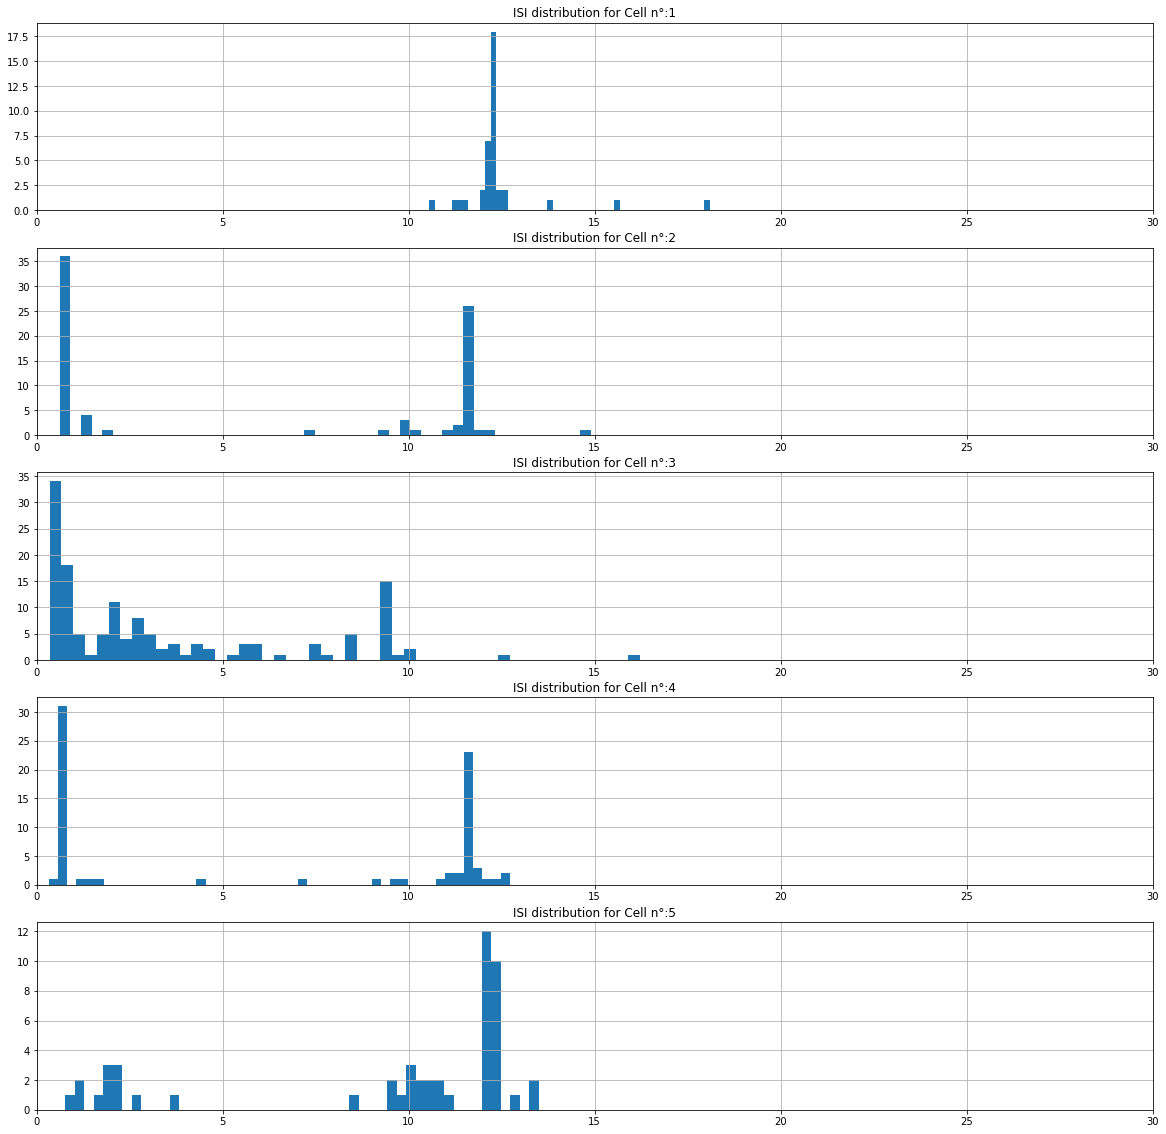

In [30]:
# Plotting the Interspike Interval distribution of the cells
all_ISI = []
ISI_1 = []
ISI_2 = []
ISI_3 = []
ISI_4 = []
ISI_5 = []

for time in range(len(spikes1)-1):
    if spikes1[time] > 300:
        diff_time = (spikes1[time+1]-spikes1[time])/40
        ISI_1.append(diff_time)
all_ISI.append(ISI_1)

for time in range(len(spikes2)-1):
    if spikes2[time] > 300:
        diff_time = (spikes2[time+1]-spikes2[time])/40
        ISI_2.append(diff_time)
all_ISI.append(ISI_2)
   
for time in range(len(spikes3)-1):
    if spikes3[time] > 300:
        diff_time = (spikes3[time+1]-spikes3[time])/40
        ISI_3.append(diff_time)
all_ISI.append(ISI_3)

for time in range(len(spikes4)-1):
    if spikes4[time] > 300:
        diff_time = (spikes4[time+1]-spikes4[time])/40
        ISI_4.append(diff_time)
all_ISI.append(ISI_4)

for time in range(len(spikes5)-1):
    if spikes5[time] > 300:
        diff_time = (spikes5[time+1]-spikes5[time])/40
        ISI_5.append(diff_time)
all_ISI.append(ISI_5)

fig = plt.figure(figsize = (20,20))

for i in range(len(all_ISI)):
    axes = fig.add_subplot(5, 1, i+1)

    axes.hist(all_ISI[i], bins=50)
    axes.set_title("ISI distribution for Cell n°:"+str(i+1))
    axes.set_xlim([0,30])
    axes.grid(True)

##### --> Explain what is observed when reducing connection weight of exponential synapses to 0.2, what do you observe ? Is your network driven more by the stimulation or the connections between the cells. Explain

#### Conclusion 3:
Finally, in this case we returned the value of the weights of cells to 1 and reduced the synapses weights to 0.2. As a result, we have witnessed a more regular and almost synchronized behavior of the cells and it is manifested in the ISI histograms, where a lot of ISI have the same values. 

### Final Conclusions:
- Strong Input + Strong Connections = Regular Firing and Asynchronous
- Strong Input + Weak Connections = Irregular Firing and Asynchronous
- Weak Input + Strong Connections = Regular Firing and Synchronous

Strong connections between the neurons of the network contribute to a stable firing behavior after the random stimulation has stopped, while the destabilising influence of the random input can be reduced by decreasing the input synapse weight.


# Ex4. Poissonian stimulus

<font size='3'>Load the five morphology reconstructions assigned to your group in week 2, using the class "Cell" defined in these tutorials. Connect the cells with the following weights: w(Pyr - Pyr) = 1, w(Pyr - Int) = 1, w(Inh - Pyr) = 1, w(Int - Int) = -0.01. Add exponential synapses (weight 1, tau = 2 ms) to a random section of the basal dendrite of each cell. 
Create two different poissonian stimulation processes for the exponential synapses of: subset1 - two excitatory neurons and one inhibitory and subset2 - one excitatory and one inhibitory neuron respectively,  with no more than 10 stimulations. Run a simulation that lasts long enough to contain the last stimulation. Plot the voltage response of each cell and spike detection.
Describe what you observe. What do you think a poissonian stimulation is useful for when simulationg networks? Is there any difference bewteen a poissonian stimulation and an irregular asynchronous stimualtion? [2 pts]

<font size='3'><font color='red'> Restart kernel out of precaution

### Defining Cell class and loading the 5 morphologies

In [1]:
# Importing useful libraries

%matplotlib inline

from neuron import h, gui
import matplotlib.pyplot as plt
import numpy as np
import random

random.seed(9)
np.random.seed(9)
# Load external files & initialize
h.load_file("stdrun.hoc");
h.stdinit();

In [2]:
class Cell:
    def __init__(self, filename, name, cell_type):
        self.name = name
        self.type = cell_type
        self.synapses = []
        self.build_morphology(filename)
        self.biophysics()
        
    def build_morphology(self, filename):
        h.load_file('import3d.hoc')
        h.load_file('stdlib.hoc')
        #morph_reader = h.Import3d_Neurolucida3()
        morph_reader = h.Import3d_SWC_read()
        morph_reader.input(filename)
        i3d = h.Import3d_GUI(morph_reader, 0)
        i3d.instantiate(self) # Notice this change to be able to instantiate several cells
    
    def biophysics(self):
        for sec in h.allsec():
            sec.Ra = 100    # Axial resistance in Ohm * cm
            sec.cm = 1      # Membrane capacitance in micro Farads / cm^2
            sec.insert("pas")
            for seg in sec:
                seg.pas.g = 0.00003
                seg.pas.e = -75
        
        # Insert passive current in the dendrite
        for sec in self.soma:
            sec.insert('hh')
            for seg in sec:
                seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
                seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2
        
        if hasattr(self, 'apic'):
            for sec in self.apic:
                sec.insert('hh')
                for seg in sec:
                    seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
                    seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2
        
        for sec in self.dend:
            sec.insert('hh')
            for seg in sec:
                seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
                seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2
                
        for sec in self.axon:
            sec.insert('hh')
            for seg in sec:    
                seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
                seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2

In [3]:
Pyr1 = Cell('morph_06.swc','Pyr1','Pyr')
Pyr2 = Cell('morph_07.swc','Pyr2','Pyr')
Pyr3 = Cell('morph_09.swc','Pyr3','Pyr')
cells_Pyr = [Pyr1, Pyr2, Pyr3]
Int1 = Cell('morph_03.swc','Int1','Int')
Int2 = Cell('morph_10.swc','Int2','Int')
cells_Int = [Int1, Int2]
cells = cells_Pyr + cells_Int

error morph_06.swc line 17828: could not parse: 
error morph_07.swc line 19678: could not parse: 
error morph_09.swc line 6173: could not parse: 
error morph_03.swc line 7281: could not parse: 
error morph_10.swc line 3377: could not parse: 


In [4]:
for c in cells_Pyr:
    print('%s: %d apical sections, %d basal sections, %d soma sections and %d axon senctions' % (c.name,len(c.apic),len(c.dend), len(c.soma), len(c.axon)))
for c in cells_Int:
    print('%s: %d basal sections, %d soma sections and %d axon senctions' % (c.name,len(c.dend), len(c.soma), len(c.axon)))

Pyr1: 95 apical sections, 72 basal sections, 2 soma sections and 131 axon senctions
Pyr2: 131 apical sections, 82 basal sections, 2 soma sections and 125 axon senctions
Pyr3: 37 apical sections, 69 basal sections, 2 soma sections and 67 axon senctions
Int1: 45 basal sections, 2 soma sections and 103 axon senctions
Int2: 33 basal sections, 2 soma sections and 120 axon senctions


### Connect the cells with following weights:

- w(Pyr-Pyr) = 1
- w(Pyr-Int) = 1
- w(Int-Pyr) = 1
- w(Int-Int) = -0.01

In [5]:
# connect two cells with an exponential synapse at given locations
# returns the netcon
def connect(source, target, weight = None, delay = 5, source_sec = None, source_neurite = 'axon', target_sec = None, target_neurite = 'dend'):
    rng = np.random.default_rng()
    
    if weight is None:
        weight = rng.uniform() # random weight
    
    target_neurite_ = getattr(target, target_neurite)
    if target_sec is None:
        target_sec = rng.integers(0,len(target_neurite_)) # random dendritic section
    
    source_neurite_ = getattr(source, source_neurite)
    if source_sec is None:
        source_sec = rng.integers(0,len(source_neurite_)) # random axonal section
    
    target_syn = h.ExpSyn(target_neurite_[target_sec](0.5))
    target.synapses.append(target_syn) # store synapse
    
    netcon = h.NetCon(source_neurite_[source_sec](0.5)._ref_v, target_syn, sec=source_neurite_[source_sec])
    netcon.weight[0] = weight
    netcon.delay = delay
    
    print('Connected cells %s -> %s with weight %g and delay %g, from %s[%d] to %s[%d]' % (source.name,target.name,weight,delay,source_neurite,source_sec,target_neurite,target_sec))
    return netcon

In [6]:
netcons = [] # save the netcons in case we want to modify them later

# Connect Pyr2 and Pyr3 to Pyr1
nc = connect(Pyr2,Pyr1,1)
netcons.append(nc)
nc = connect(Pyr3,Pyr1,1)
netcons.append(nc)
nc = connect(Int1,Pyr1,weight = 1, target_neurite='soma')
netcons.append(nc)
nc = connect(Int2,Pyr1,weight = 1, target_neurite='soma')
netcons.append(nc)

# Connect Pyr1 and Pyr3 to Pyr2
nc = connect(Pyr1,Pyr2,weight = 1)
netcons.append(nc)
nc = connect(Pyr3,Pyr2,weight = 1)
netcons.append(nc)
nc = connect(Int1,Pyr2,weight = 1, target_neurite='soma')
netcons.append(nc)
nc = connect(Int2,Pyr2,weight = 1, target_neurite='soma')
netcons.append(nc)

# Connect Pyr1 and Pyr2 to Pyr3
nc = connect(Pyr1,Pyr3,weight = 1)
netcons.append(nc)
nc = connect(Pyr2,Pyr3,weight = 1)
netcons.append(nc)
nc = connect(Int1,Pyr3,weight = 1, target_neurite='soma')
netcons.append(nc)
nc = connect(Int2,Pyr3,weight = 1, target_neurite='soma')
netcons.append(nc)


# Connect Pyr1, Pyr2, Pyr3, and Int2 to Int1
nc = connect(Pyr1,Int1,weight = 1)
netcons.append(nc)
nc = connect(Pyr2,Int1,weight = 1)
netcons.append(nc)
nc = connect(Pyr3,Int1,weight = 1)
netcons.append(nc)
nc = connect(Int2,Int1,weight = -0.01, target_neurite='soma')
netcons.append(nc)

# Connect Pyr1, Pyr2, Pyr3, and Int1 to Int2
nc = connect(Pyr1,Int2,weight = 1)
netcons.append(nc)
nc = connect(Pyr2,Int2,weight = 1)
netcons.append(nc)
nc = connect(Pyr3,Int2,weight = 1)
netcons.append(nc)
nc = connect(Int1,Int2,weight = -0.01, target_neurite='soma')
netcons.append(nc)

Connected cells Pyr2 -> Pyr1 with weight 1 and delay 5, from axon[45] to dend[47]
Connected cells Pyr3 -> Pyr1 with weight 1 and delay 5, from axon[12] to dend[6]
Connected cells Int1 -> Pyr1 with weight 1 and delay 5, from axon[20] to soma[0]
Connected cells Int2 -> Pyr1 with weight 1 and delay 5, from axon[52] to soma[1]
Connected cells Pyr1 -> Pyr2 with weight 1 and delay 5, from axon[98] to dend[6]
Connected cells Pyr3 -> Pyr2 with weight 1 and delay 5, from axon[21] to dend[40]
Connected cells Int1 -> Pyr2 with weight 1 and delay 5, from axon[72] to soma[0]
Connected cells Int2 -> Pyr2 with weight 1 and delay 5, from axon[72] to soma[0]
Connected cells Pyr1 -> Pyr3 with weight 1 and delay 5, from axon[87] to dend[46]
Connected cells Pyr2 -> Pyr3 with weight 1 and delay 5, from axon[33] to dend[54]
Connected cells Int1 -> Pyr3 with weight 1 and delay 5, from axon[52] to soma[1]
Connected cells Int2 -> Pyr3 with weight 1 and delay 5, from axon[55] to soma[0]
Connected cells Pyr1 -> 

### Adding exponential Synapses

With weight = 1, and $\tau = 2$ms

In [7]:
import random
# Place exponential synapses in random cell sections
random.seed(9)
np.random.seed(9)
# Exponential synapses
# Cell 1
sec1 = random.randint(0, len(Pyr1.dend)-1)
stim_cell1 = Pyr1
synapse1 = h.ExpSyn(stim_cell1.dend[sec1](0.5))
synapse1.tau = 2 # ms
print ('Stimulus apply in basal section num %s of Pyr1' %sec1)

# Cell 2
sec2 = random.randint(0, len(Pyr2.dend)-1)
stim_cell2 = Pyr2
synapse2 = h.ExpSyn(stim_cell2.dend[sec2](0.5))
synapse2.tau = 2 # ms
print ('Stimulus apply in basal section num %s of Pyr2' %sec2)

# Cell 3
stim_cell3 = Pyr3
sec3 = random.randint(0, len(Pyr3.dend)-1)
synapse3 = h.ExpSyn(stim_cell3.dend[sec3](0.5))
synapse3.tau = 2 # ms
print ('Stimulus apply in basal section num %s of Pyr3' %sec3)

# Cell 4
stim_cell4 = Int1
sec4 = random.randint(0, len(Int1.dend)-1)
synapse4 = h.ExpSyn(stim_cell4.dend[sec4](0.5))
synapse4.tau = 2 # ms
print ('Stimulus apply in basal section num %s of Inh1' %sec4)

# Cell 5
stim_cell5 = Int2
sec5 = random.randint(0, len(Int2.dend)-1)
synapse5 = h.ExpSyn(stim_cell5.dend[sec5](0.5))
synapse5.tau = 2 # ms
print ('Stimulus apply in basal section num %s of Inh2' %sec5)

Stimulus apply in basal section num 59 of Pyr1
Stimulus apply in basal section num 78 of Pyr2
Stimulus apply in basal section num 47 of Pyr3
Stimulus apply in basal section num 17 of Inh1
Stimulus apply in basal section num 8 of Inh2


### Create 2 different Poissonian stimulation processes for the exponential synapses of:

- subset 1: two excitatory neurons + one inhibitory neuron
- subset 2: one excitatory and one inhibitory neuron

With no more than 10 stimulations

According to the logic of [this paper](https://www.sciencedirect.com/science/article/abs/pii/0165027095000968
), we have implemented the poisson process by starting with an initial value and then selecting a random number from the poisson distribution whos expectation value ($\lambda$) was arbitrarily set to 20.

In [8]:
# Given that the previous exercises, the stimulations values span up to 200ms, we set the mean "time" between two stimulations at 20ms
lambda_ = 20.0
random.seed(9)
np.random.seed(9)
# Create random stimulation times
stim_times1 = [20.0]
for t in range(1, 9):
    n = np.random.poisson(lambda_)
    step = stim_times1[t-1] + n
    stim_times1.append(step)

stim_times2 = [30.0]
for t in range(1, 9):
    n = np.random.poisson(lambda_)
    step = stim_times2[t-1] + n
    stim_times2.append(step)

stim_times3 = [10.0]
for t in range(1, 9):
    n = np.random.poisson(lambda_)
    step = stim_times3[t-1] + n
    stim_times3.append(step)
    
# Check what is the output
print('stimulation interval 1 = %s' %stim_times1)
print('stimulation interval 2 = %s' %stim_times2)
print('stimulation interval 3 = %s' %stim_times3)


stimulation interval 1 = [20.0, 40.0, 54.0, 73.0, 85.0, 115.0, 138.0, 165.0, 186.0]
stimulation interval 2 = [30.0, 48.0, 73.0, 102.0, 124.0, 158.0, 185.0, 203.0, 224.0]
stimulation interval 3 = [10.0, 30.0, 56.0, 79.0, 107.0, 129.0, 148.0, 156.0, 180.0]


### Subset 1: Two Excitatory neurons + One Inhibitory neuron:
##### Run a stimulation that lasts long enough to contain last stimulation

In [9]:
# Stimulator
stimulator1 = h.VecStim()
spike_times1 = stim_times1
spikes_vector1 = h.Vector(spike_times1)
stimulator1.play(spikes_vector1)

stimulator2 = h.VecStim()
spike_times2 = stim_times2
spikes_vector2 = h.Vector(spike_times2)
stimulator2.play(spikes_vector2)

stimulator3 = h.VecStim()
spike_times3 = stim_times3
spikes_vector3 = h.Vector(spike_times3)
stimulator3.play(spikes_vector3)

connection_weight = 1.0

connection1 = h.NetCon(stimulator1, synapse1)
connection1.weight[0] = connection_weight        # In units of [nS] due to the gmax scaling factor in our .mod file
connection2 = h.NetCon(stimulator2, synapse2)
connection2.weight[0] = connection_weight        # In units of [nS] due to the gmax scaling factor in our .mod file
connection3 = h.NetCon(stimulator3, synapse4)
connection3.weight[0] = connection_weight        # In units of [nS] due to the gmax scaling factor in our .mod file

In [10]:
recording_cell1 = Pyr1
recording_cell2 = Pyr2
recording_cell3 = Pyr3
recording_cell4 = Int1
recording_cell5 = Int2

soma_v1 = h.Vector().record(recording_cell1.soma[0](0.5)._ref_v)
soma_v2 = h.Vector().record(recording_cell2.soma[0](0.5)._ref_v)
soma_v3 = h.Vector().record(recording_cell3.soma[0](0.5)._ref_v)
soma_v4 = h.Vector().record(recording_cell4.soma[0](0.5)._ref_v)
soma_v5 = h.Vector().record(recording_cell5.soma[0](0.5)._ref_v)

time = h.Vector().record(h._ref_t)

h.finitialize(-65)
h.continuerun(500)

0.0

##### Plot voltage response of each cell and spike detection

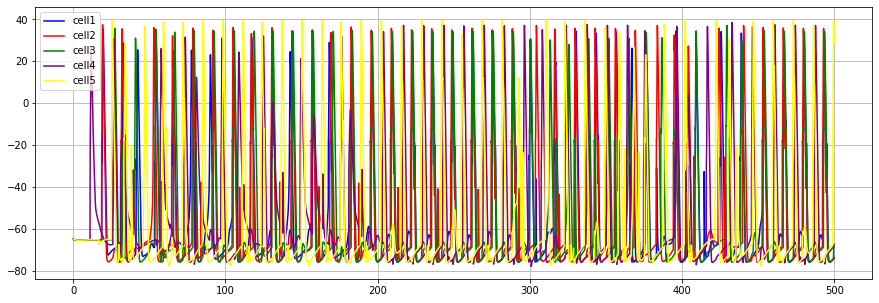

In [11]:
plt.figure(figsize=(15,5))
plt.plot(time, soma_v1, label='cell1', color='blue')
plt.plot(time, soma_v2, label='cell2', color='red')
plt.plot(time, soma_v3, label='cell3', color='green')
plt.plot(time, soma_v4, label='cell4', color='purple')
plt.plot(time, soma_v5, label='cell5', color='yellow')
plt.legend()
plt.grid(True)
plt.show()

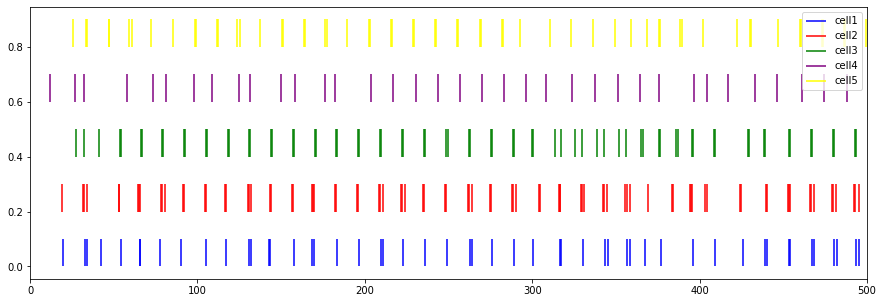

In [12]:
from scipy.signal import find_peaks

def spike_detector(voltage, threshold):
    # convert Neuron recording (voltage) to list
    voltage_read = []
    for v in voltage:
        voltage_read.append(v)
    # peak locations
    spike_time, _ = find_peaks(voltage_read, height=threshold)
    return spike_time

spikes1 = spike_detector(soma_v1, -20.0)
spikes2 = spike_detector(soma_v2, -20.0)
spikes3 = spike_detector(soma_v3, -20.0)
spikes4 = spike_detector(soma_v4, -20.0)
spikes5 = spike_detector(soma_v5, -20.0)

plt.figure(figsize=(15,5))
plt.vlines(spikes1/40, ymin=0, ymax=0.1, color='blue', label='cell1')
plt.vlines(spikes2/40, ymin=0.2, ymax=0.3, color='red', label='cell2')
plt.vlines(spikes3/40, ymin=0.4, ymax=0.5, color='green', label='cell3')
plt.vlines(spikes4/40, ymin=0.6, ymax=0.7, color='purple', label='cell4')
plt.vlines(spikes5/40, ymin=0.8, ymax=0.9, color='yellow', label='cell5')
plt.xlim((0, 500))
plt.legend()

#### During Stimulation ISI Histogram

In [15]:
threshold = 40*300

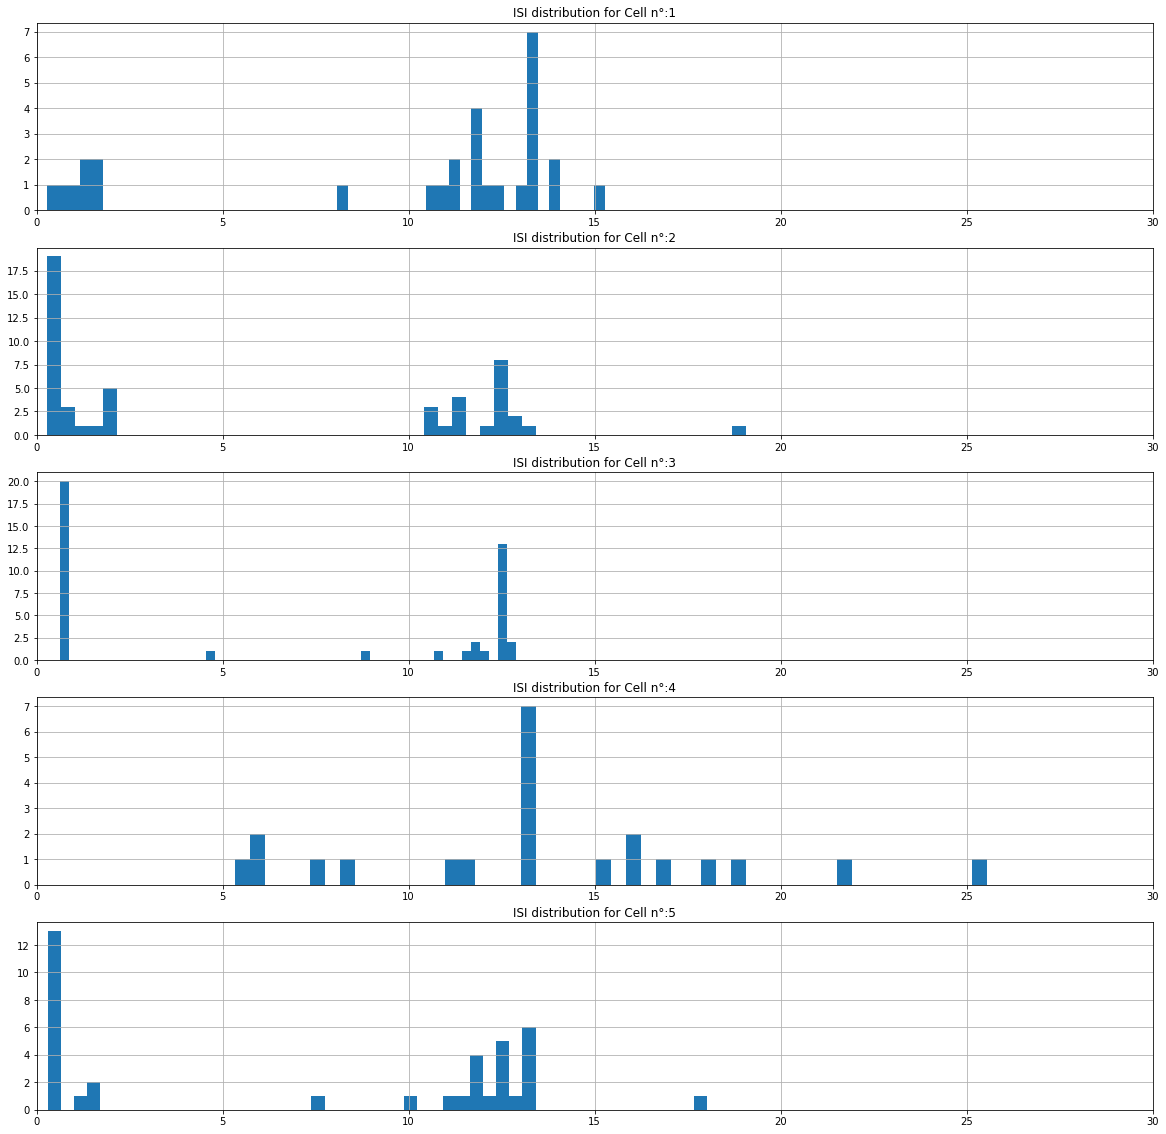

In [16]:
# Plotting the Interspike Interval distribution of the cells
all_ISI = []
ISI_1 = []
ISI_2 = []
ISI_3 = []
ISI_4 = []
ISI_5 = []

for time in range(len(spikes1)-1):
    if spikes1[time] < threshold:
        diff_time = (spikes1[time+1]-spikes1[time])/40
        ISI_1.append(diff_time)
all_ISI.append(ISI_1)

for time in range(len(spikes2)-1):
    if spikes2[time] < threshold:
        diff_time = (spikes2[time+1]-spikes2[time])/40
        ISI_2.append(diff_time)
all_ISI.append(ISI_2)
   
for time in range(len(spikes3)-1):
    if spikes3[time] < threshold:
        diff_time = (spikes3[time+1]-spikes3[time])/40
        ISI_3.append(diff_time)
all_ISI.append(ISI_3)

for time in range(len(spikes4)-1):
    if spikes4[time] < threshold:
        diff_time = (spikes4[time+1]-spikes4[time])/40
        ISI_4.append(diff_time)
all_ISI.append(ISI_4)

for time in range(len(spikes5)-1):
    if spikes5[time] < threshold:
        diff_time = (spikes5[time+1]-spikes5[time])/40
        ISI_5.append(diff_time)
all_ISI.append(ISI_5)

fig = plt.figure(figsize = (20,20))

for i in range(len(all_ISI)):
    axes = fig.add_subplot(5, 1, i+1)

    axes.hist(all_ISI[i], bins=50)
    axes.set_title("ISI distribution for Cell n°:"+str(i+1))
    axes.set_xlim([0,30])
    axes.grid(True)

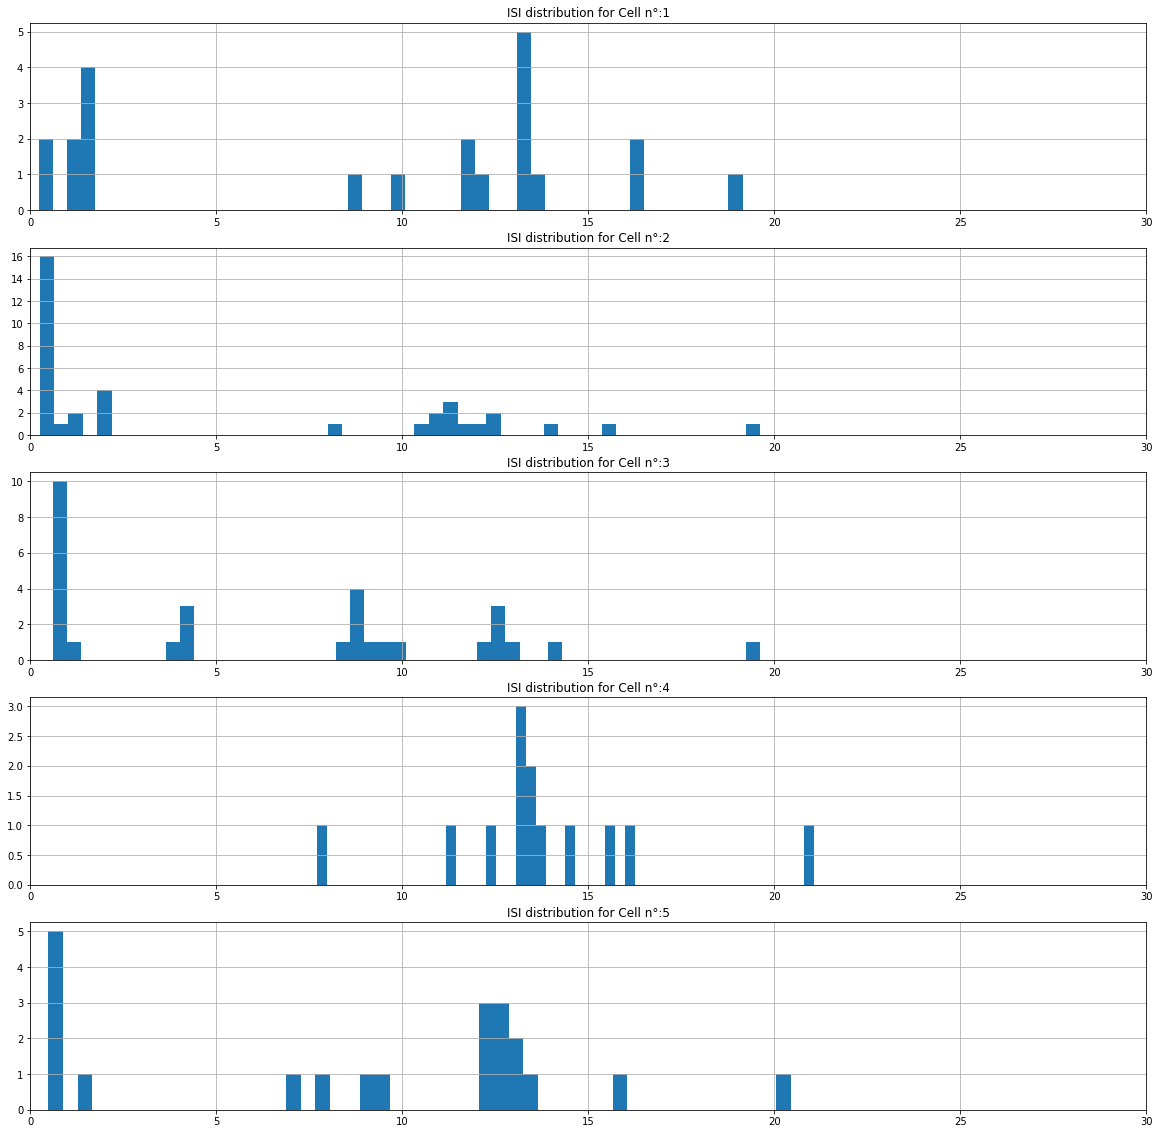

In [17]:
# Plotting the Interspike Interval distribution of the cells
all_ISI = []
ISI_1 = []
ISI_2 = []
ISI_3 = []
ISI_4 = []
ISI_5 = []

for time in range(len(spikes1)-1):
    if spikes1[time] > threshold:
        diff_time = (spikes1[time+1]-spikes1[time])/40
        ISI_1.append(diff_time)
all_ISI.append(ISI_1)

for time in range(len(spikes2)-1):
    if spikes2[time] > threshold:
        diff_time = (spikes2[time+1]-spikes2[time])/40
        ISI_2.append(diff_time)
all_ISI.append(ISI_2)
   
for time in range(len(spikes3)-1):
    if spikes3[time] > threshold:
        diff_time = (spikes3[time+1]-spikes3[time])/40
        ISI_3.append(diff_time)
all_ISI.append(ISI_3)

for time in range(len(spikes4)-1):
    if spikes4[time] > threshold:
        diff_time = (spikes4[time+1]-spikes4[time])/40
        ISI_4.append(diff_time)
all_ISI.append(ISI_4)

for time in range(len(spikes5)-1):
    if spikes5[time] > threshold:
        diff_time = (spikes5[time+1]-spikes5[time])/40
        ISI_5.append(diff_time)
all_ISI.append(ISI_5)

fig = plt.figure(figsize = (20,20))

for i in range(len(all_ISI)):
    axes = fig.add_subplot(5, 1, i+1)

    axes.hist(all_ISI[i], bins=50)
    axes.set_title("ISI distribution for Cell n°:"+str(i+1))
    axes.set_xlim([0,30])
    axes.grid(True)

### Subset 2: One Excitatory Neuron and One Inhibitory Neuron
##### Run a stimulation that lasts long enough to contain last stimulation

In [22]:
# Stimulator
stimulator1 = h.VecStim()
spike_times1 = stim_times1
spikes_vector1 = h.Vector(spike_times1)
stimulator1.play(spikes_vector1)

stimulator3 = h.VecStim()
spike_times3 = stim_times3
spikes_vector3 = h.Vector(spike_times3)
stimulator3.play(spikes_vector3)


connection_weight = 1.0

connection1 = h.NetCon(stimulator1, synapse1)
connection1.weight[0] = connection_weight        # In units of [nS] due to the gmax scaling factor in our .mod file
connection2 = h.NetCon(stimulator2, synapse2)
connection2.weight[0] = 0       # In units of [nS] due to the gmax scaling factor in our .mod file
connection3 = h.NetCon(stimulator3, synapse4)
connection3.weight[0] = connection_weight        # In units of [nS] due to the gmax scaling factor in our .mod file

In [23]:
recording_cell1 = Pyr1
recording_cell2 = Pyr2
recording_cell3 = Pyr3
recording_cell4 = Int1
recording_cell5 = Int2

soma_v1 = h.Vector().record(recording_cell1.soma[0](0.5)._ref_v)
soma_v2 = h.Vector().record(recording_cell2.soma[0](0.5)._ref_v)
soma_v3 = h.Vector().record(recording_cell3.soma[0](0.5)._ref_v)
soma_v4 = h.Vector().record(recording_cell4.soma[0](0.5)._ref_v)
soma_v5 = h.Vector().record(recording_cell5.soma[0](0.5)._ref_v)

time = h.Vector().record(h._ref_t)

h.finitialize(-65)
h.continuerun(500)

0.0

##### Plot voltage response of each cell and spike detection

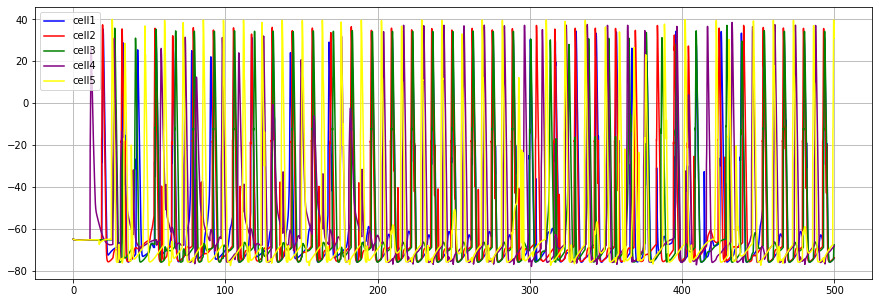

In [24]:
plt.figure(figsize=(15,5))
plt.plot(time, soma_v1, label='cell1', color='blue')
plt.plot(time, soma_v2, label='cell2', color='red')
plt.plot(time, soma_v3, label='cell3', color='green')
plt.plot(time, soma_v4, label='cell4', color='purple')
plt.plot(time, soma_v5, label='cell5', color='yellow')
plt.legend()
plt.grid(True)
plt.show()

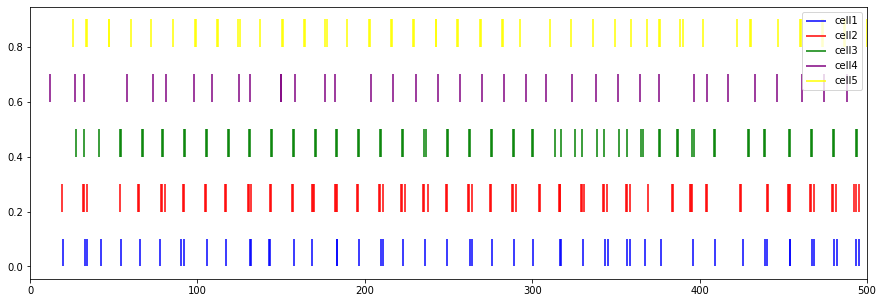

In [25]:
from scipy.signal import find_peaks

def spike_detector(voltage, threshold):
    # convert Neuron recording (voltage) to list
    voltage_read = []
    for v in voltage:
        voltage_read.append(v)
    # peak locations
    spike_time, _ = find_peaks(voltage_read, height=threshold)
    return spike_time

spikes1 = spike_detector(soma_v1, -20.0)
spikes2 = spike_detector(soma_v2, -20.0)
spikes3 = spike_detector(soma_v3, -20.0)
spikes4 = spike_detector(soma_v4, -20.0)
spikes5 = spike_detector(soma_v5, -20.0)

plt.figure(figsize=(15,5))
plt.vlines(spikes1/40, ymin=0, ymax=0.1, color='blue', label='cell1')
plt.vlines(spikes2/40, ymin=0.2, ymax=0.3, color='red', label='cell2')
plt.vlines(spikes3/40, ymin=0.4, ymax=0.5, color='green', label='cell3')
plt.vlines(spikes4/40, ymin=0.6, ymax=0.7, color='purple', label='cell4')
plt.vlines(spikes5/40, ymin=0.8, ymax=0.9, color='yellow', label='cell5')
plt.xlim((0, 500))
plt.legend()

#### During Stimulation ISI Histogram"

In [26]:
threshold = 300*40

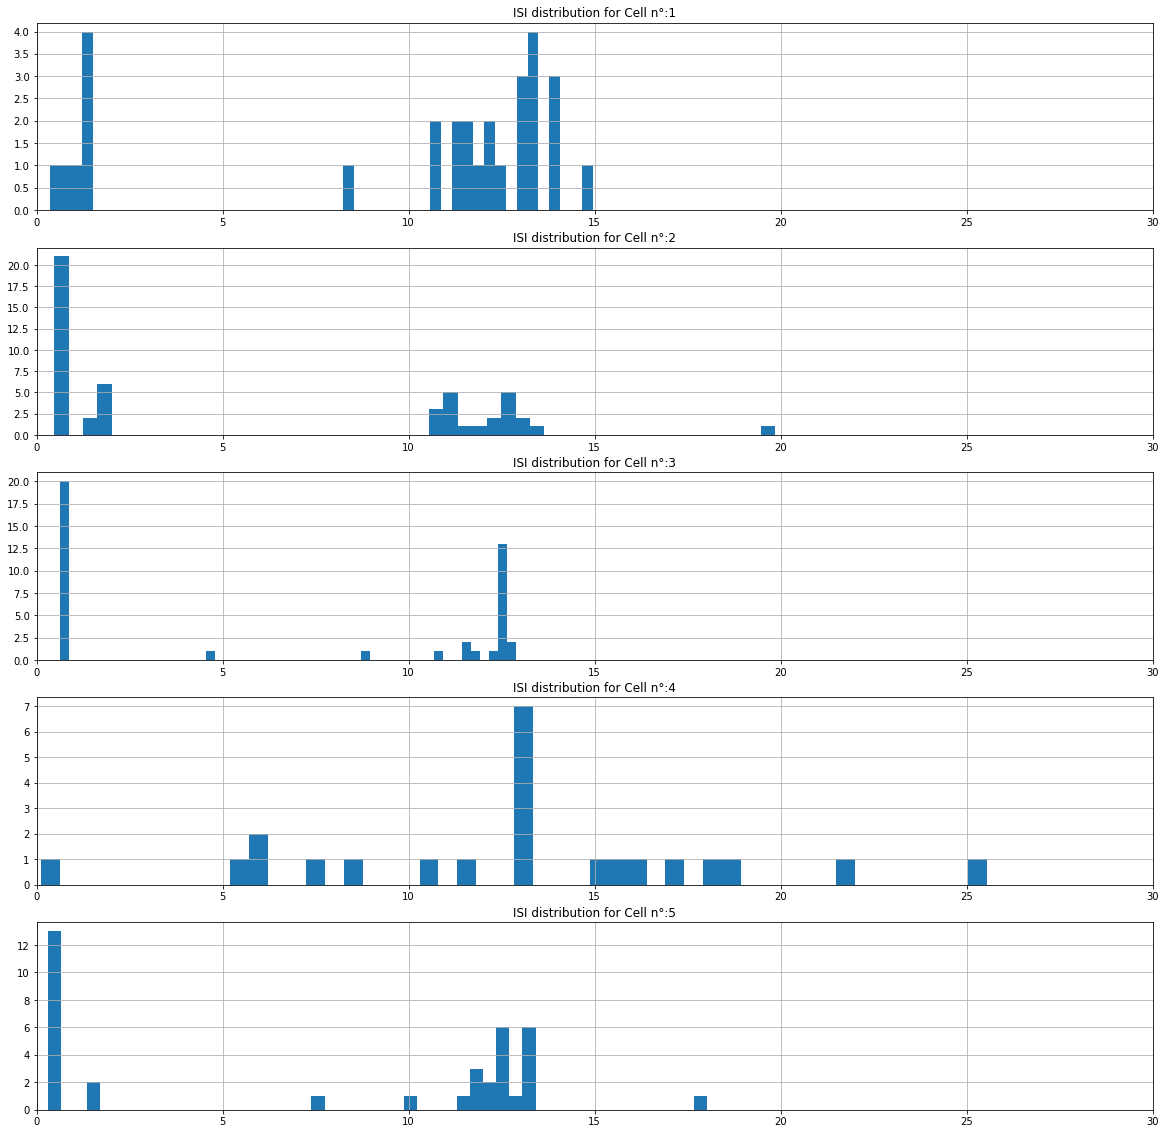

In [27]:
# Plotting the Interspike Interval distribution of the cells
all_ISI = []
ISI_1 = []
ISI_2 = []
ISI_3 = []
ISI_4 = []
ISI_5 = []

for time in range(len(spikes1)-1):
    if spikes1[time] < threshold:
        diff_time = (spikes1[time+1]-spikes1[time])/40
        ISI_1.append(diff_time)
all_ISI.append(ISI_1)

for time in range(len(spikes2)-1):
    if spikes2[time] < threshold:
        diff_time = (spikes2[time+1]-spikes2[time])/40
        ISI_2.append(diff_time)
all_ISI.append(ISI_2)
   
for time in range(len(spikes3)-1):
    if spikes3[time] < threshold:
        diff_time = (spikes3[time+1]-spikes3[time])/40
        ISI_3.append(diff_time)
all_ISI.append(ISI_3)

for time in range(len(spikes4)-1):
    if spikes4[time] < threshold:
        diff_time = (spikes4[time+1]-spikes4[time])/40
        ISI_4.append(diff_time)
all_ISI.append(ISI_4)

for time in range(len(spikes5)-1):
    if spikes5[time] < threshold:
        diff_time = (spikes5[time+1]-spikes5[time])/40
        ISI_5.append(diff_time)
all_ISI.append(ISI_5)

fig = plt.figure(figsize = (20,20))

for i in range(len(all_ISI)):
    axes = fig.add_subplot(5, 1, i+1)

    axes.hist(all_ISI[i], bins=50)
    axes.set_title("ISI distribution for Cell n°:"+str(i+1))
    axes.set_xlim([0,30])
    axes.grid(True)

#### Post Stimulation ISI Histogram

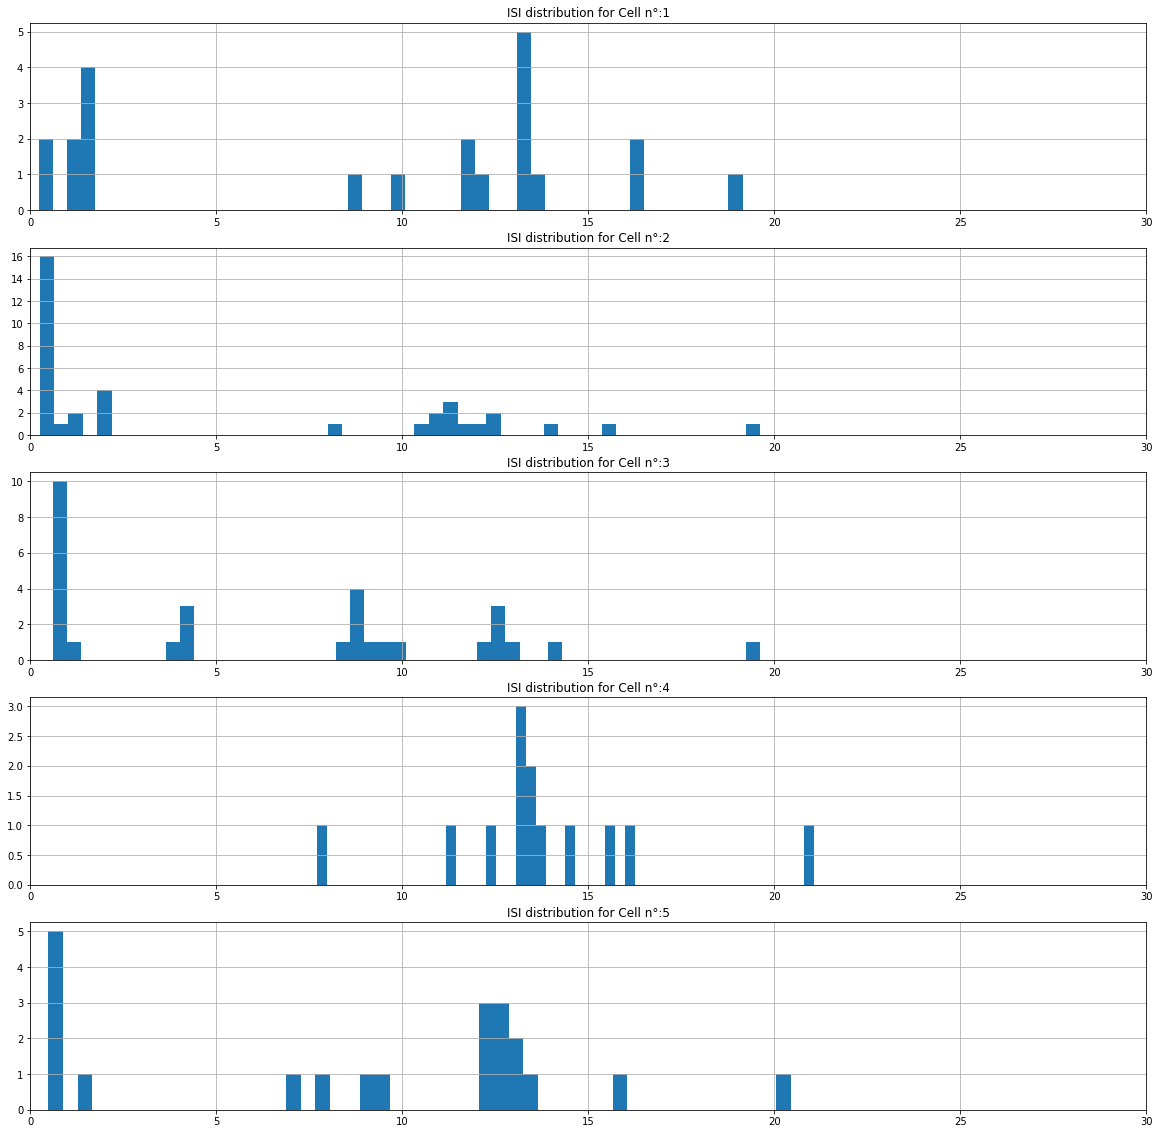

In [28]:
# Plotting the Interspike Interval distribution of the cells
all_ISI = []
ISI_1 = []
ISI_2 = []
ISI_3 = []
ISI_4 = []
ISI_5 = []

for time in range(len(spikes1)-1):
    if spikes1[time] > threshold:
        diff_time = (spikes1[time+1]-spikes1[time])/40
        ISI_1.append(diff_time)
all_ISI.append(ISI_1)

for time in range(len(spikes2)-1):
    if spikes2[time] > threshold:
        diff_time = (spikes2[time+1]-spikes2[time])/40
        ISI_2.append(diff_time)
all_ISI.append(ISI_2)
   
for time in range(len(spikes3)-1):
    if spikes3[time] > threshold:
        diff_time = (spikes3[time+1]-spikes3[time])/40
        ISI_3.append(diff_time)
all_ISI.append(ISI_3)

for time in range(len(spikes4)-1):
    if spikes4[time] > threshold:
        diff_time = (spikes4[time+1]-spikes4[time])/40
        ISI_4.append(diff_time)
all_ISI.append(ISI_4)

for time in range(len(spikes5)-1):
    if spikes5[time] > threshold:
        diff_time = (spikes5[time+1]-spikes5[time])/40
        ISI_5.append(diff_time)
all_ISI.append(ISI_5)

fig = plt.figure(figsize = (20,20))

for i in range(len(all_ISI)):
    axes = fig.add_subplot(5, 1, i+1)

    axes.hist(all_ISI[i], bins=50)
    axes.set_title("ISI distribution for Cell n°:"+str(i+1))
    axes.set_xlim([0,30])
    axes.grid(True)

### ___Question___: What do you think a poissonian stimulation is useful for when simulating networks? 

Poissonian stimulations are used to generate stimulation patterns by simulating spike trains. It has been posited that Poisson-like spike trains are the fundamental unit of cortical communication as stated in [this paper](https://www.sciencedirect.com/science/article/pii/S0896627309003250).

According to [another paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1329656/): The simplest representation of the result of convergence of multiple inputs is a Poisson process. Thus, this indicates that to most accurately represent the convergence of multiple inputs onto a cell is using a Poisson process.

### ___Question___: Describe what you observe. Is there any difference between a poissonian stimulation and an irregular asynchronous stimulation?

When we compare between both histograms (ISI) in Ex2 (Irregular Asynchronous) and Ex4 (Poissonian), it is observed the in the former case during stimulation the cells are firing irregularly and in an asynchronous pattern (broader ISI histogram) while after stimulation the cells get synchronized and firing in a regular manner (narrower ISI histogram).

On the other hand, in the latter case (poissonian stimulation), one can notice that the cells were induced into a synchronized regime during firing (narrower ISI histogram) and got desynchronized after stimulation (broader ISI histogram).

Moreover, to precisely compare the Raster plots between both subsets, a gif was created:

![SegmentLocal](W10Es4.gif "segment")

As seen above, only small variations can be identified.

<font size='3'><font color='red'>__IMPORTANT!!__ The code from the tutorials generates random connections between cells, if you want to compare results you have to keep the same connections (same axon section connected to same basal section) between the cells. The same happens with the location of the exponential synapses.